# Name: Varun Kumar Bhogoju
# WSUID: J893G242

In [ ]:


#!unzip -q /train.zip -d /content/dataset_dogs_vs_cats/

In [ ]:
#rm -r /content/dataset_dogs_vs_cats/test

### Importing Libraries

In [2]:
#Import Required Libraries
import os
from os import makedirs
from os import listdir
from shutil import copyfile, move
from random import seed
from random import random
import numpy as np
import pandas as pd

In [119]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Directory Creation and segregating  Files

In [7]:
# create directories
dataset_home = '/content/dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']

for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.2
# copy training dataset images into subdirectories
src_directory = '/content/dataset_dogs_vs_cats/train'
for file in listdir(src_directory):
        src = src_directory + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('cat') and file.endswith('.jpg'):
            dst = dataset_home + dst_dir + 'cats/' + file
            move(src, dst)
        elif file.startswith('dog') and file.endswith('.jpg'):
            dst = dataset_home + dst_dir + 'dogs/' + file
            move(src, dst)

### Train Test Images Split

In [8]:
path1 = "/content/dataset_dogs_vs_cats/train/cats"
path2 = "/content/dataset_dogs_vs_cats/train/dogs"
path3 = "/content/dataset_dogs_vs_cats/test/cats"
path4 = "/content/dataset_dogs_vs_cats/test/dogs"


print('Then number of cat images in training data is' ,len(os.listdir(path1)))
print('Then number of dog images in training data is' ,len(os.listdir(path2)))
print('Then number of cat images in validation data is' ,len(os.listdir(path3)))
print('Then number of dog images in validation data is' ,len(os.listdir(path4)))

Then number of cat images in training data is 9917
Then number of dog images in training data is 9994
Then number of cat images in validation data is 2583
Then number of dog images in validation data is 2506


### Defining Constants

In [89]:
# Constants
IMAGE_SIZE = (64, 64) # Most of the people chosing this image size gave better results and hence i am using this
BATCH_SIZE = 32
EPOCHS = 12  # We can increase this for better results
LEARNING_RATE = 0.001

In [10]:
# Load and preprocess the data
train_data_dir = '/content/dataset_dogs_vs_cats/train'
test_data_dir = '/content/dataset_dogs_vs_cats/test'

### Data Augmentation

In [90]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [91]:
# Validation set without augmentation
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
#test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [92]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification (Dogs vs. Cats)
)

Found 19911 images belonging to 2 classes.


In [93]:
validation_generator = val_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5089 images belonging to 2 classes.


### CNN Model Implementation

In [102]:
# VGG-like model with Batch Normalization and Dropout
def create_vgg_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Dropout layer

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Dropout layer

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Dropout layer

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Dropout layer
    x = Dense(1, activation='sigmoid')(x)  # Binary classification output

    model = Model(inputs=inputs, outputs=x)
    return model

In [103]:
model = create_vgg_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


### Model Compilation

In [104]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [105]:
# Train the model
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    validation_steps=validation_generator.samples // BATCH_SIZE)


Epoch 1/12
622/622 [==============================] - 452s 723ms/step - loss: 0.7014 - accuracy: 0.6446 - val_loss: 0.5680 - val_accuracy: 0.7054
Epoch 2/12
622/622 [==============================] - 447s 719ms/step - loss: 0.5301 - accuracy: 0.7311 - val_loss: 0.7310 - val_accuracy: 0.6519
Epoch 3/12
622/622 [==============================] - 449s 721ms/step - loss: 0.4675 - accuracy: 0.7764 - val_loss: 0.6228 - val_accuracy: 0.7357
Epoch 4/12
622/622 [==============================] - 434s 697ms/step - loss: 0.4071 - accuracy: 0.8125 - val_loss: 0.3812 - val_accuracy: 0.8249
Epoch 5/12
622/622 [==============================] - 447s 718ms/step - loss: 0.3615 - accuracy: 0.8394 - val_loss: 0.3993 - val_accuracy: 0.8158
Epoch 6/12
622/622 [==============================] - 436s 701ms/step - loss: 0.3379 - accuracy: 0.8507 - val_loss: 0.3426 - val_accuracy: 0.8551
Epoch 7/12
622/622 [==============================] - 446s 718ms/step - loss: 0.3140 - accuracy: 0.8641 - val_loss: 0.2913 -

### Model Summary

In [106]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_35 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_36 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 32, 32, 32)        0   

### Training and Validation Error

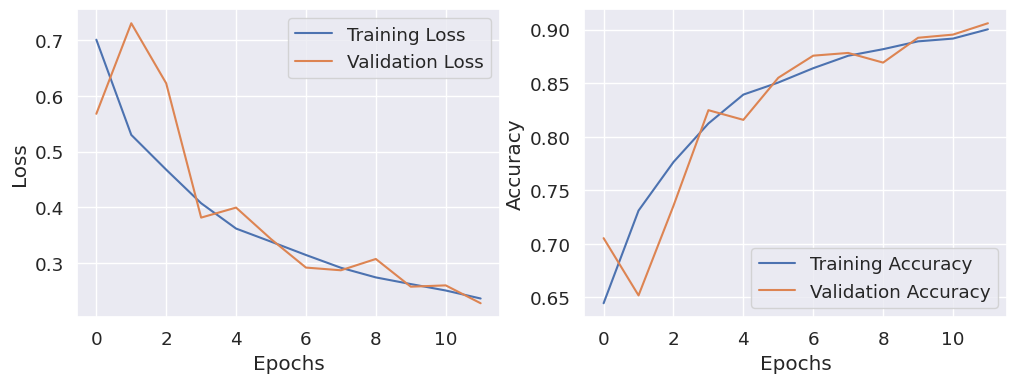

In [107]:
# Plot training and validation errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### Model Evaluation

In [108]:
# Evaluate for train generator
loss,acc = model.evaluate(train_generator,batch_size = BATCH_SIZE, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(validation_generator,batch_size = BATCH_SIZE, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 90.12606143951416
The Loss of the model for training data is: 0.2319648563861847
The accuracy of the model for validation data is: 90.60719013214111
The Loss of the model for validation data is: 0.22709321975708008


In [114]:
# Save the Model
model.save("model.keras")

### Visual Analysis - Misclassified Examples

In [117]:
# Visual analysis - misclassified and uncertain examples
def visualize_misclassified_examples():
    misclassified_images = []
    uncertain_images = []
    for batch, labels in validation_generator:
        predictions = model.predict(batch)
        for i in range(len(labels)):
            if labels[i] != round(predictions[i][0]):
                misclassified_images.append(batch[i])
            elif abs(predictions[i][0] - 0.5) < 0.1:
                uncertain_images.append(batch[i])
        if len(misclassified_images) >= 5 and len(uncertain_images) >= 5:
            break

    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(misclassified_images[i])
        plt.title("Misclassified")

        plt.subplot(2, 5, i + 6)
        plt.imshow(uncertain_images[i])
        plt.title("Uncertain")

    plt.show()

1/1 [==============================] - 0s 159ms/step


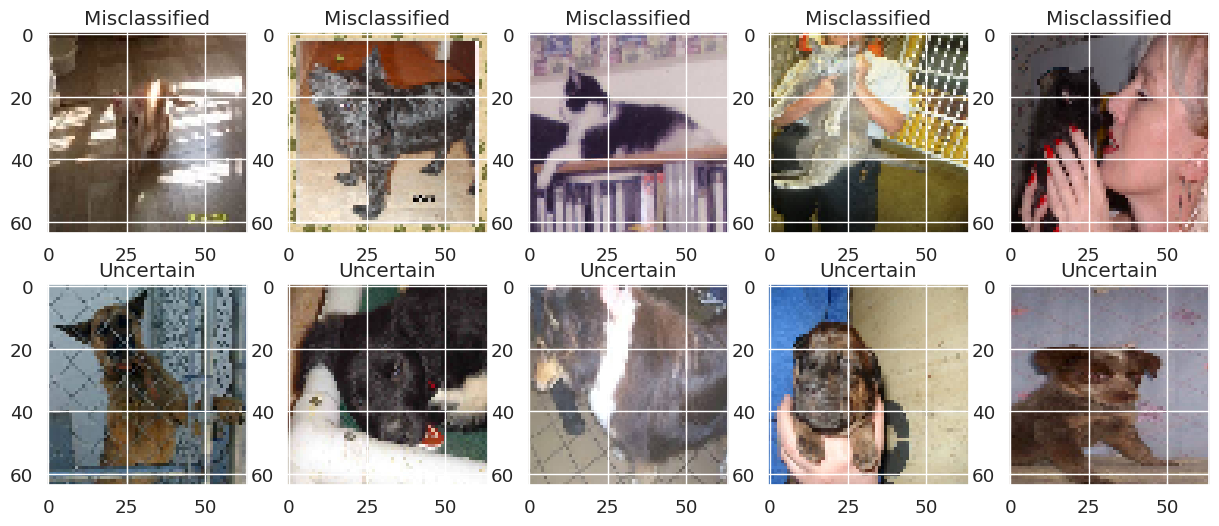

In [118]:
visualize_misclassified_examples()

<ipython-input-47-15b96de3a85b>:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i + 1)
<ipython-input-47-15b96de3a85b>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)
<ipython-input-47-15b96de3a85b>:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i + 6)


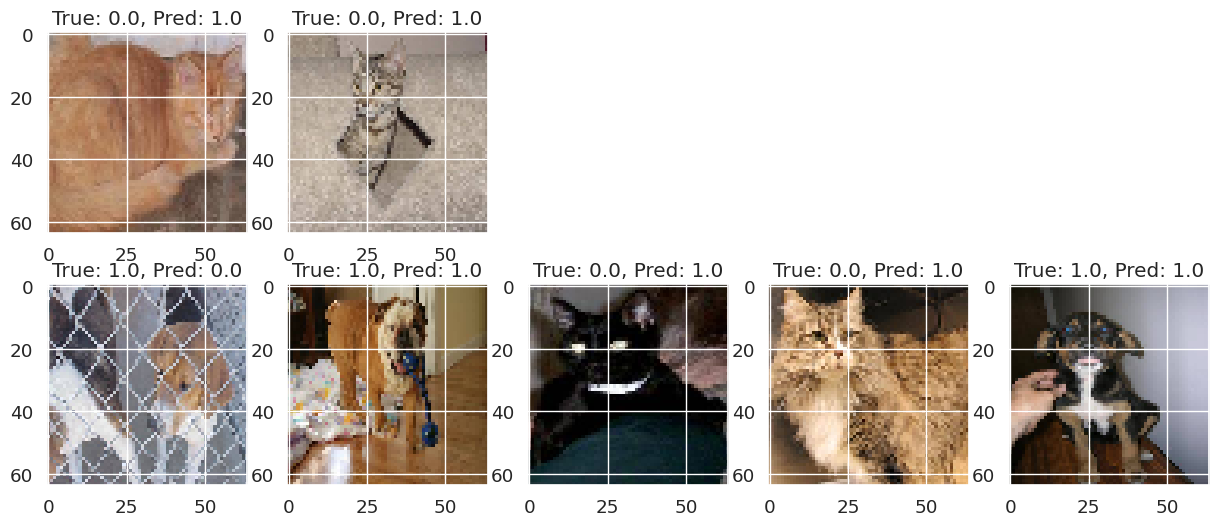

In [47]:
# Visual analysis - misclassified examples and examples around 50%
def visualize_examples(validation_generator, predicted_labels, predicted_probabilities):
    # Get test data and true labels
    test_images, true_labels = [], []
    for i in range(len(validation_generator)):
        batch_images, batch_labels = next(validation_generator)
        test_images.extend(batch_images)
        true_labels.extend(batch_labels)

    test_images = np.array(test_images)
    true_labels = np.array(true_labels)

    # Find misclassified examples
    misclassified_indices = np.where(true_labels != predicted_labels)[0]

    # Find examples with predictions around 50%
    uncertain_indices = np.where(np.abs(predicted_probabilities - 0.5) < 0.1)[0]

    # Plot misclassified examples
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Misclassified Examples")
    for i, idx in enumerate(misclassified_indices[:5]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(test_images[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")

    # Plot examples with predictions around 50%
    plt.subplot(1, 2, 2)
    plt.title("Predictions Around 50%")
    for i, idx in enumerate(uncertain_indices[:5]):
        plt.subplot(2, 5, i + 6)
        plt.imshow(test_images[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")

    plt.show()

# Visualize misclassified and uncertain examples
visualize_examples(validation_generator, predicted_labels, predictions)


### Feature Map Visualization

1/1 [==============================] - 0s 197ms/step


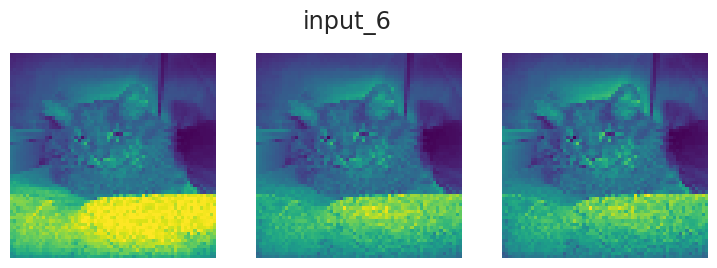

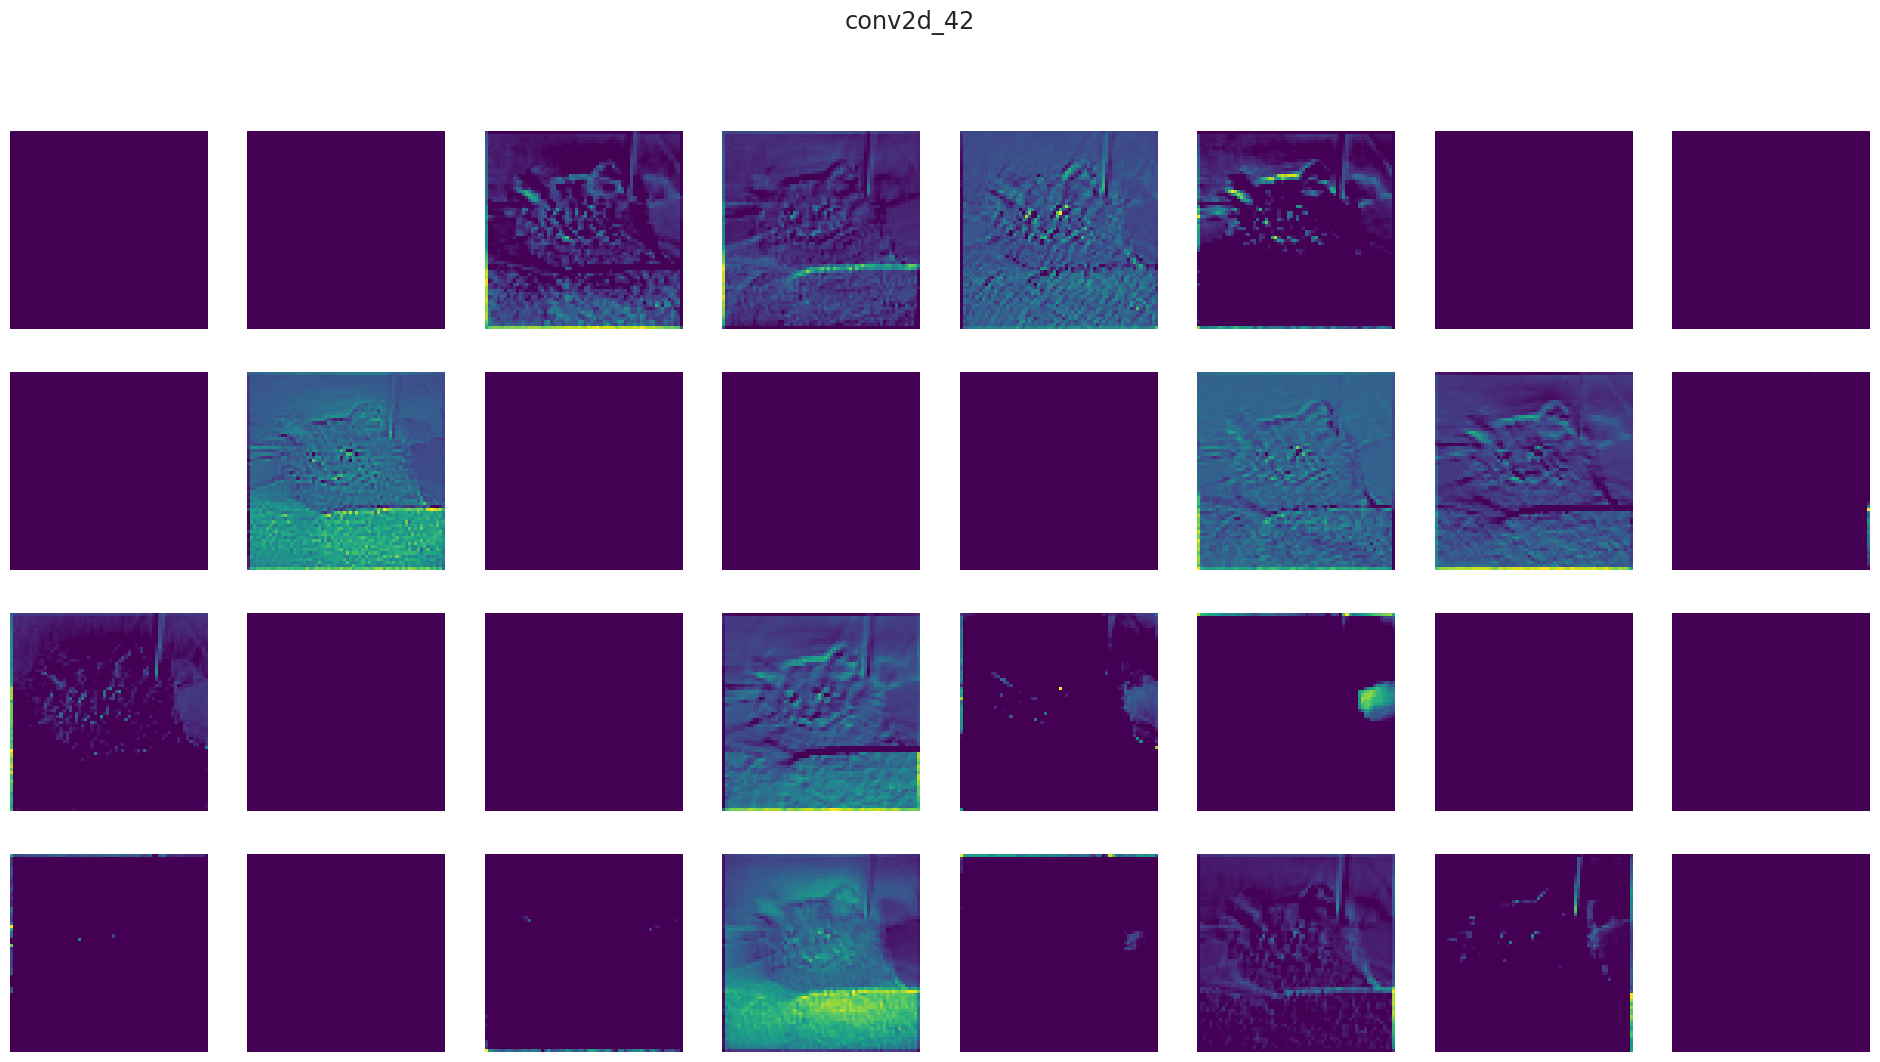

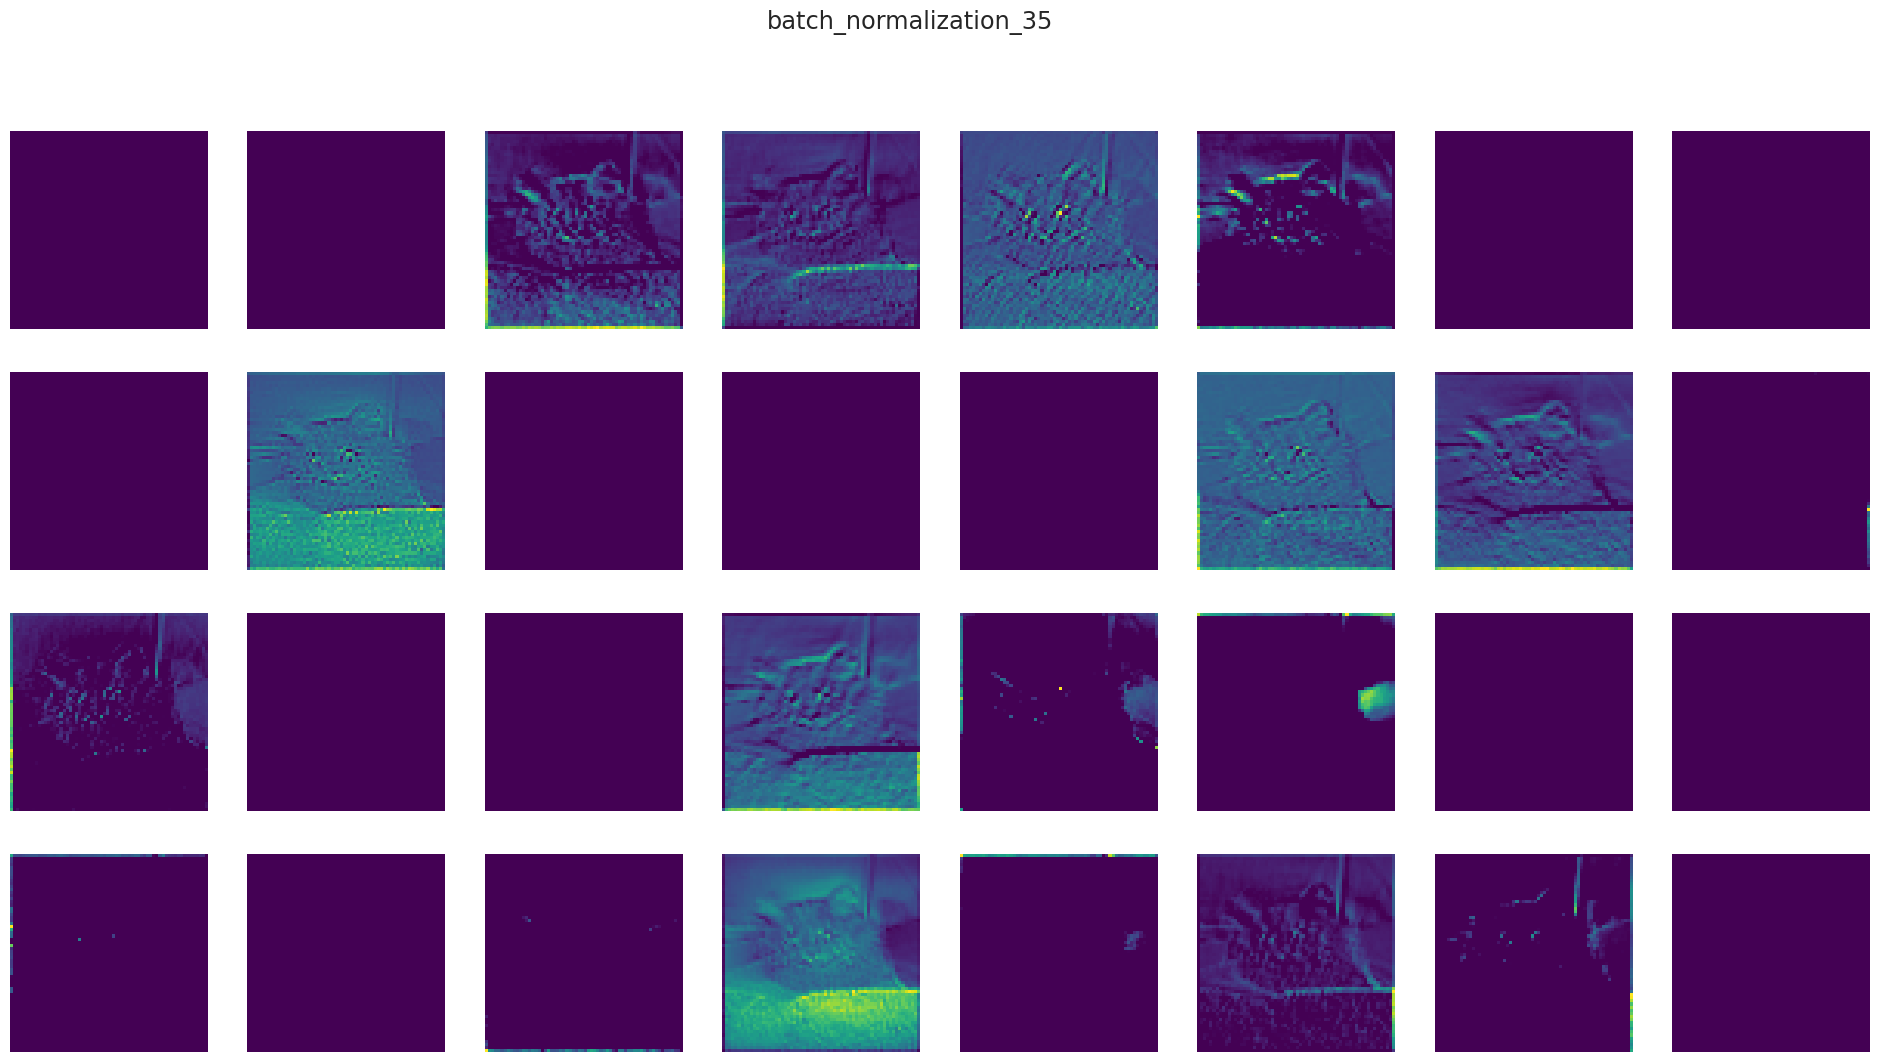

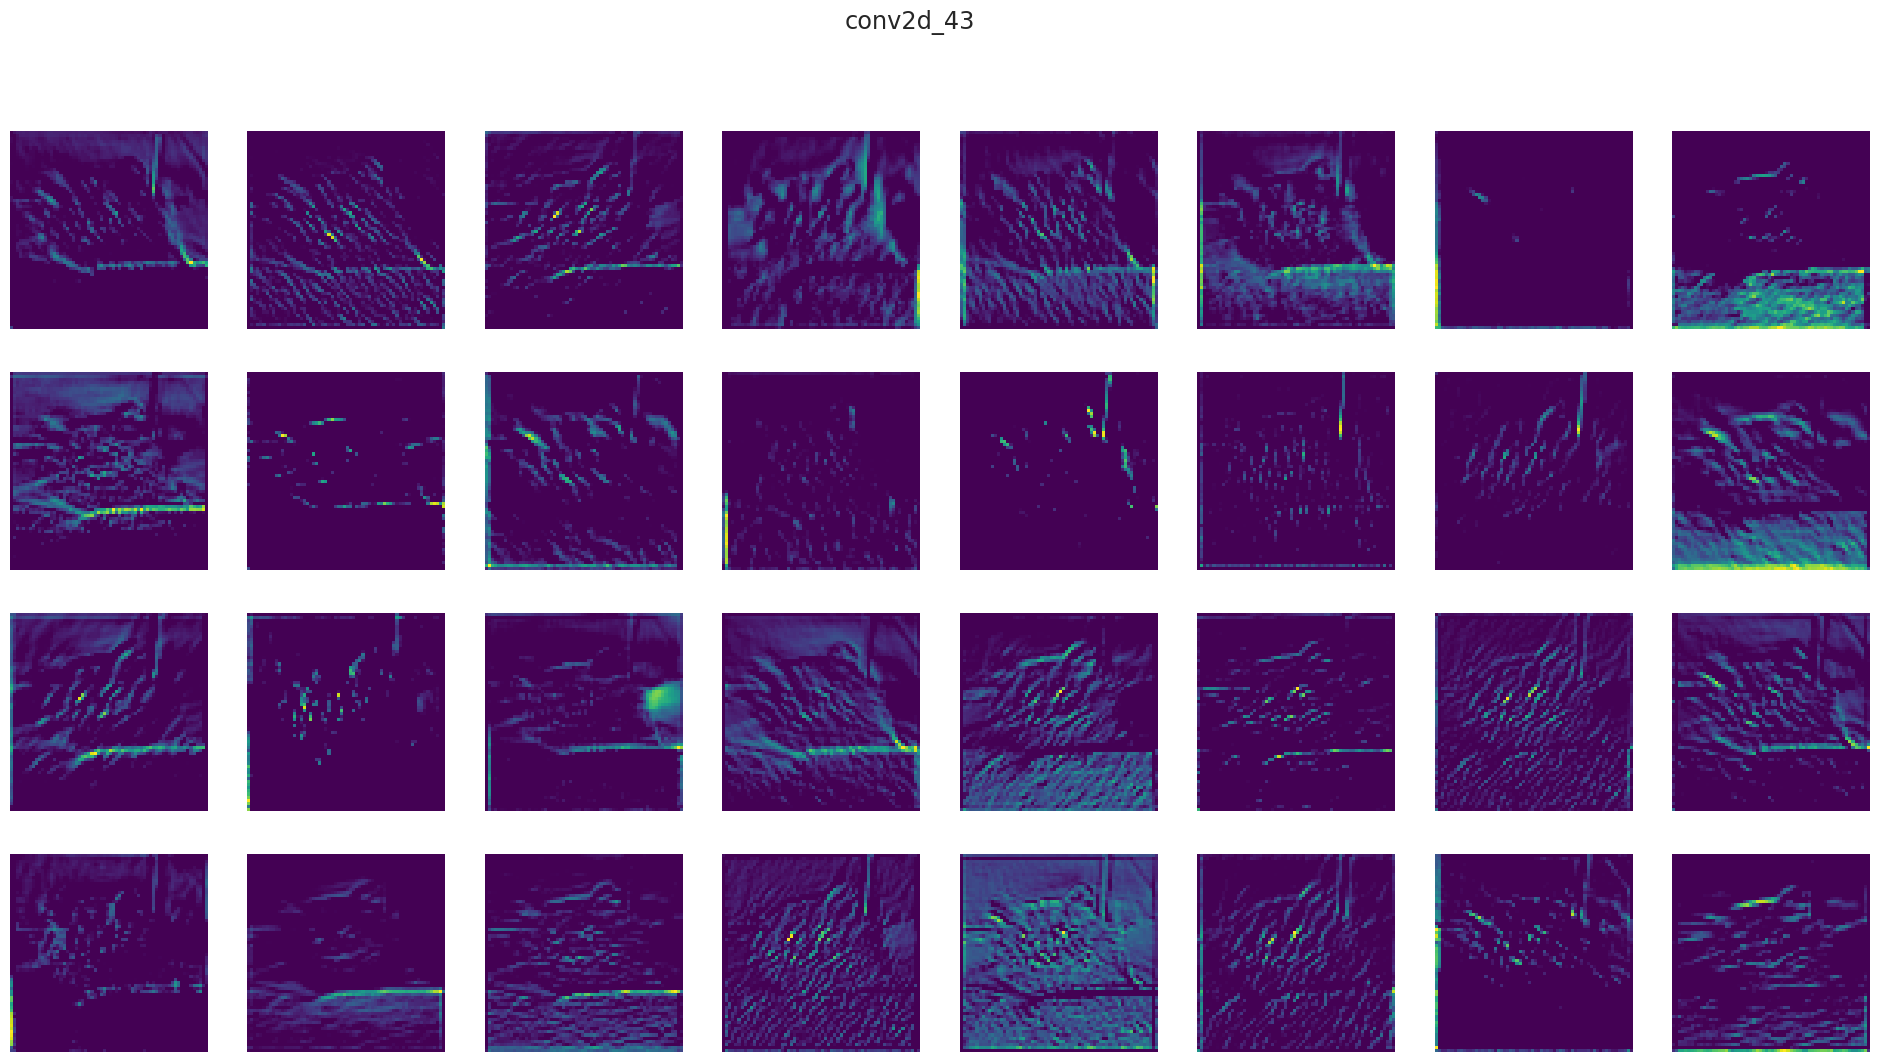

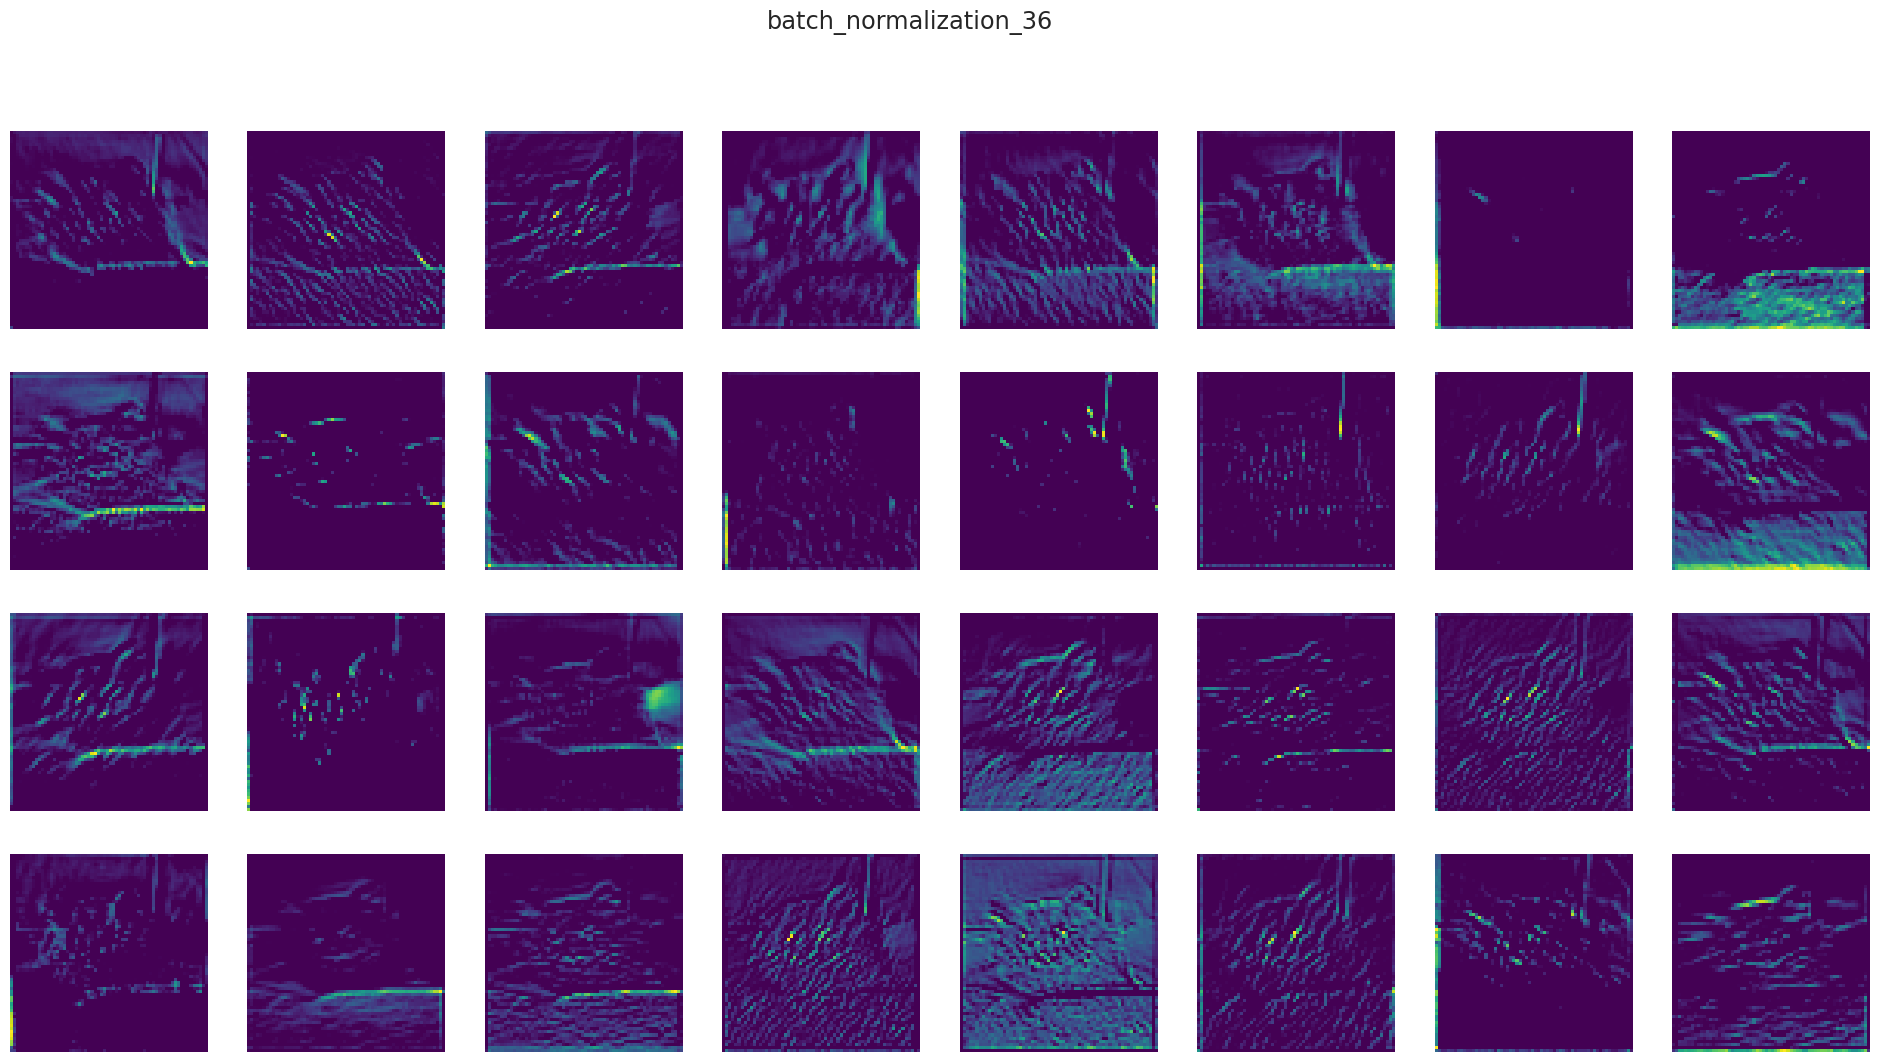

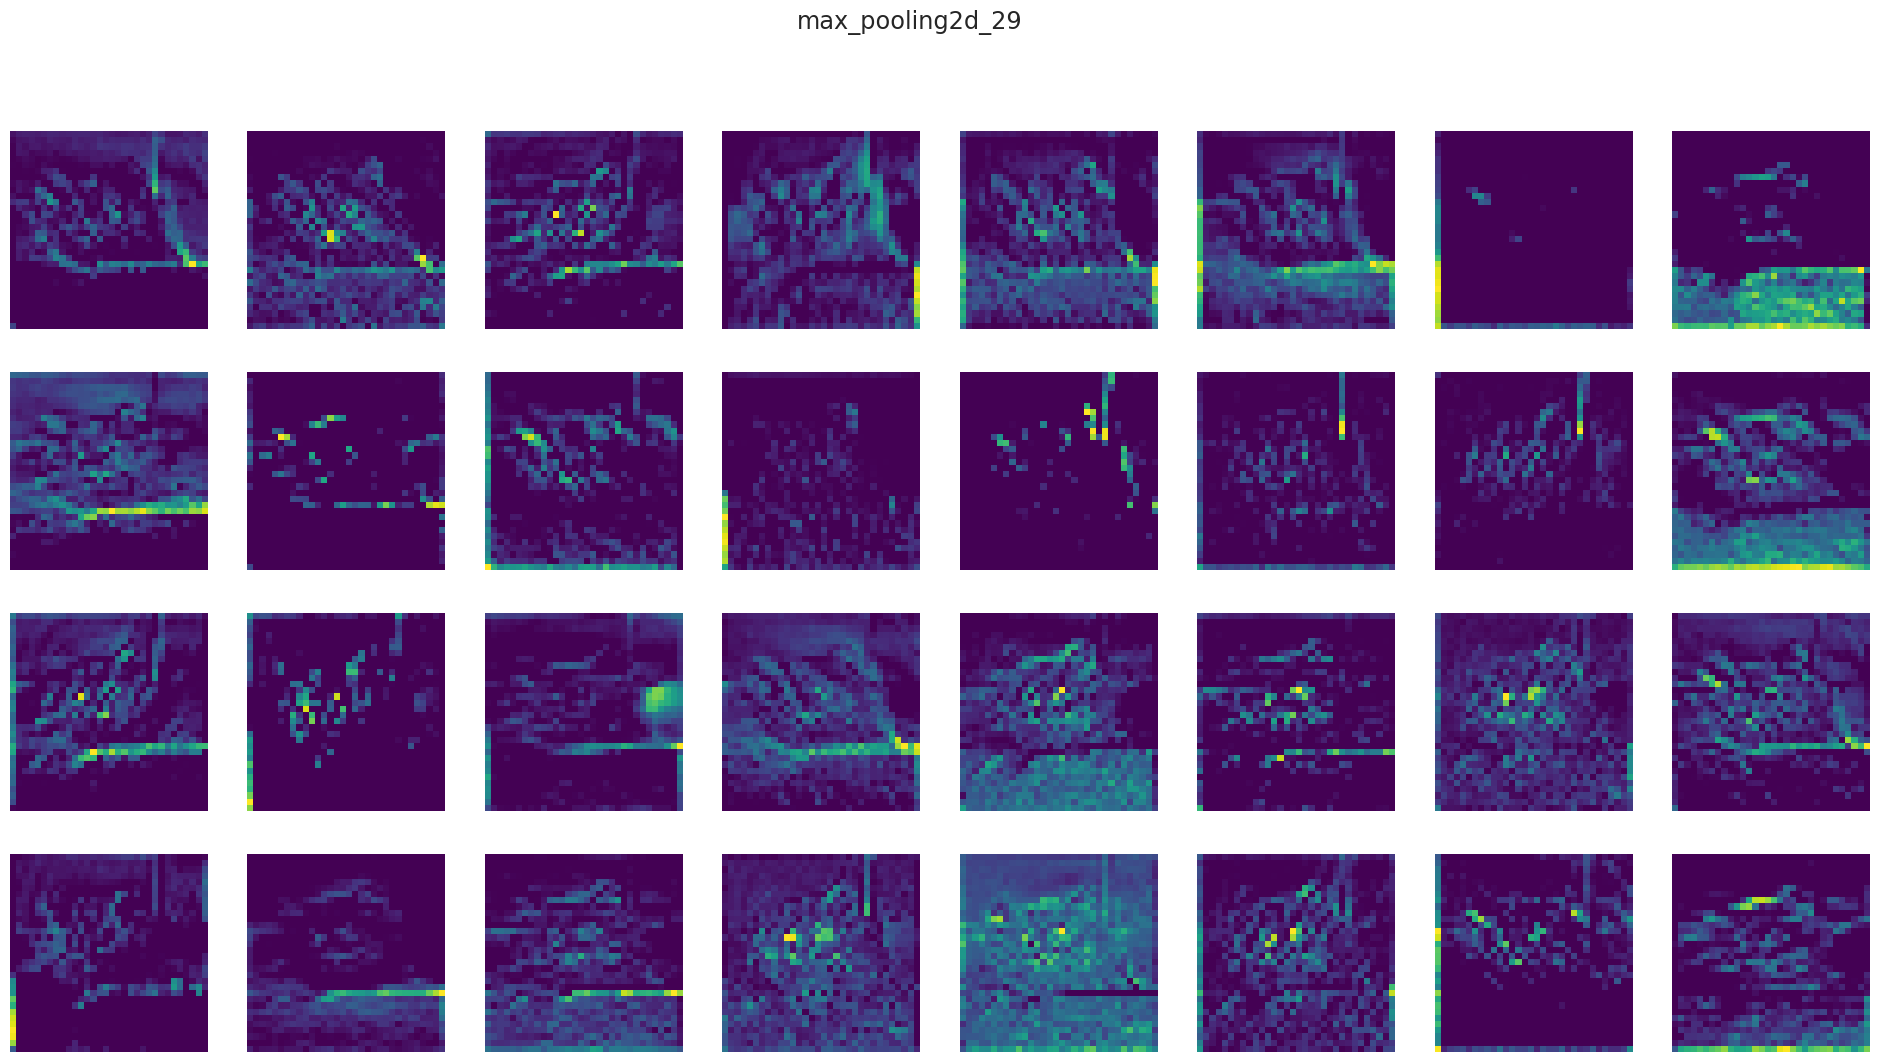

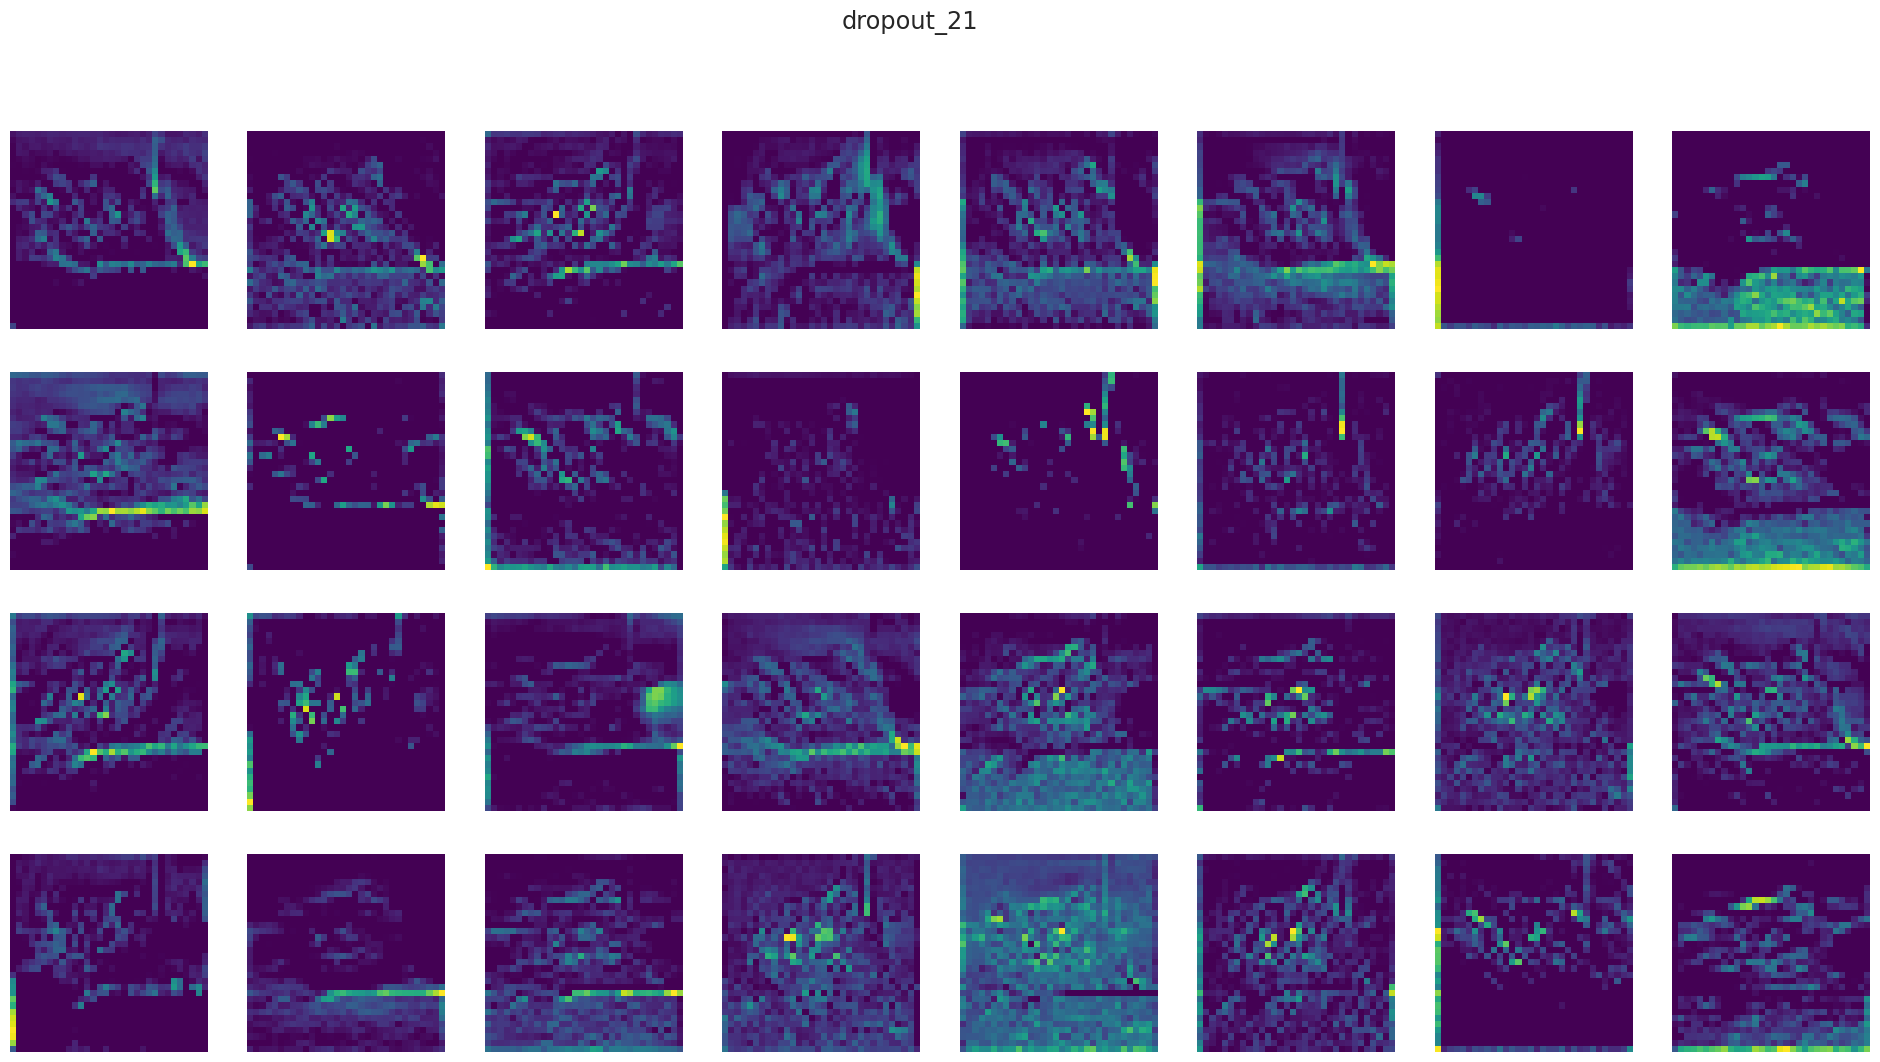

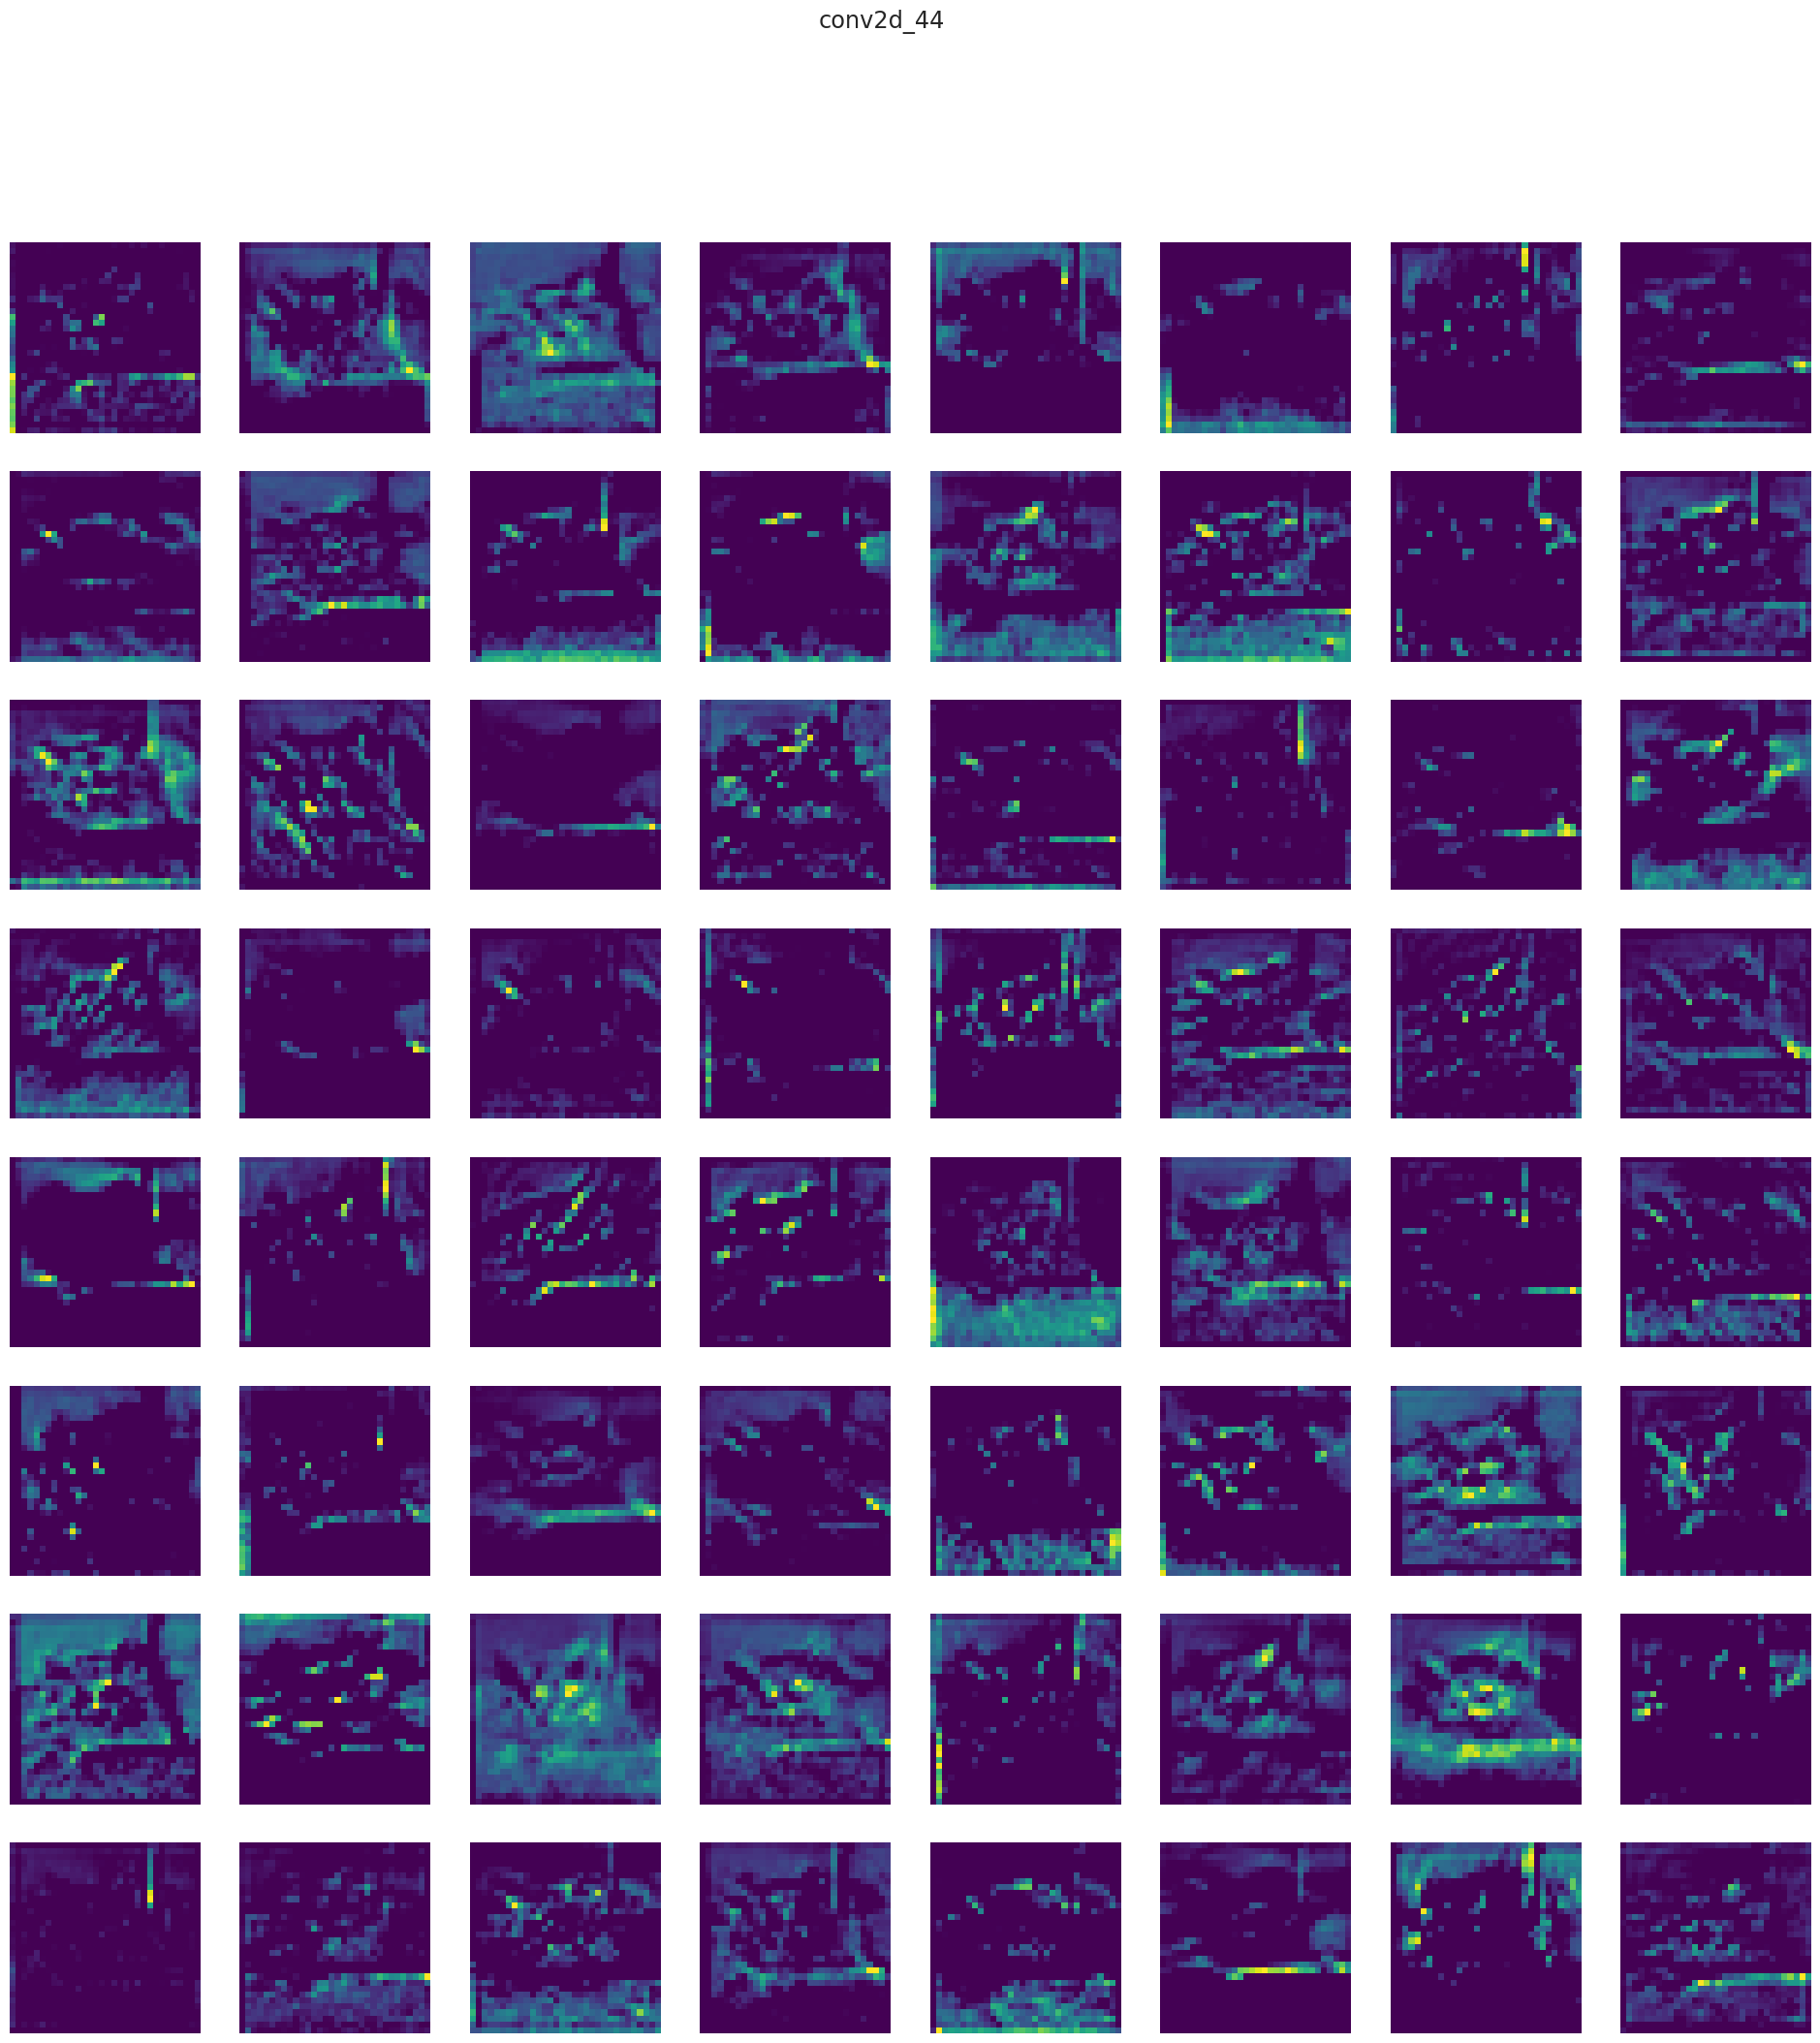

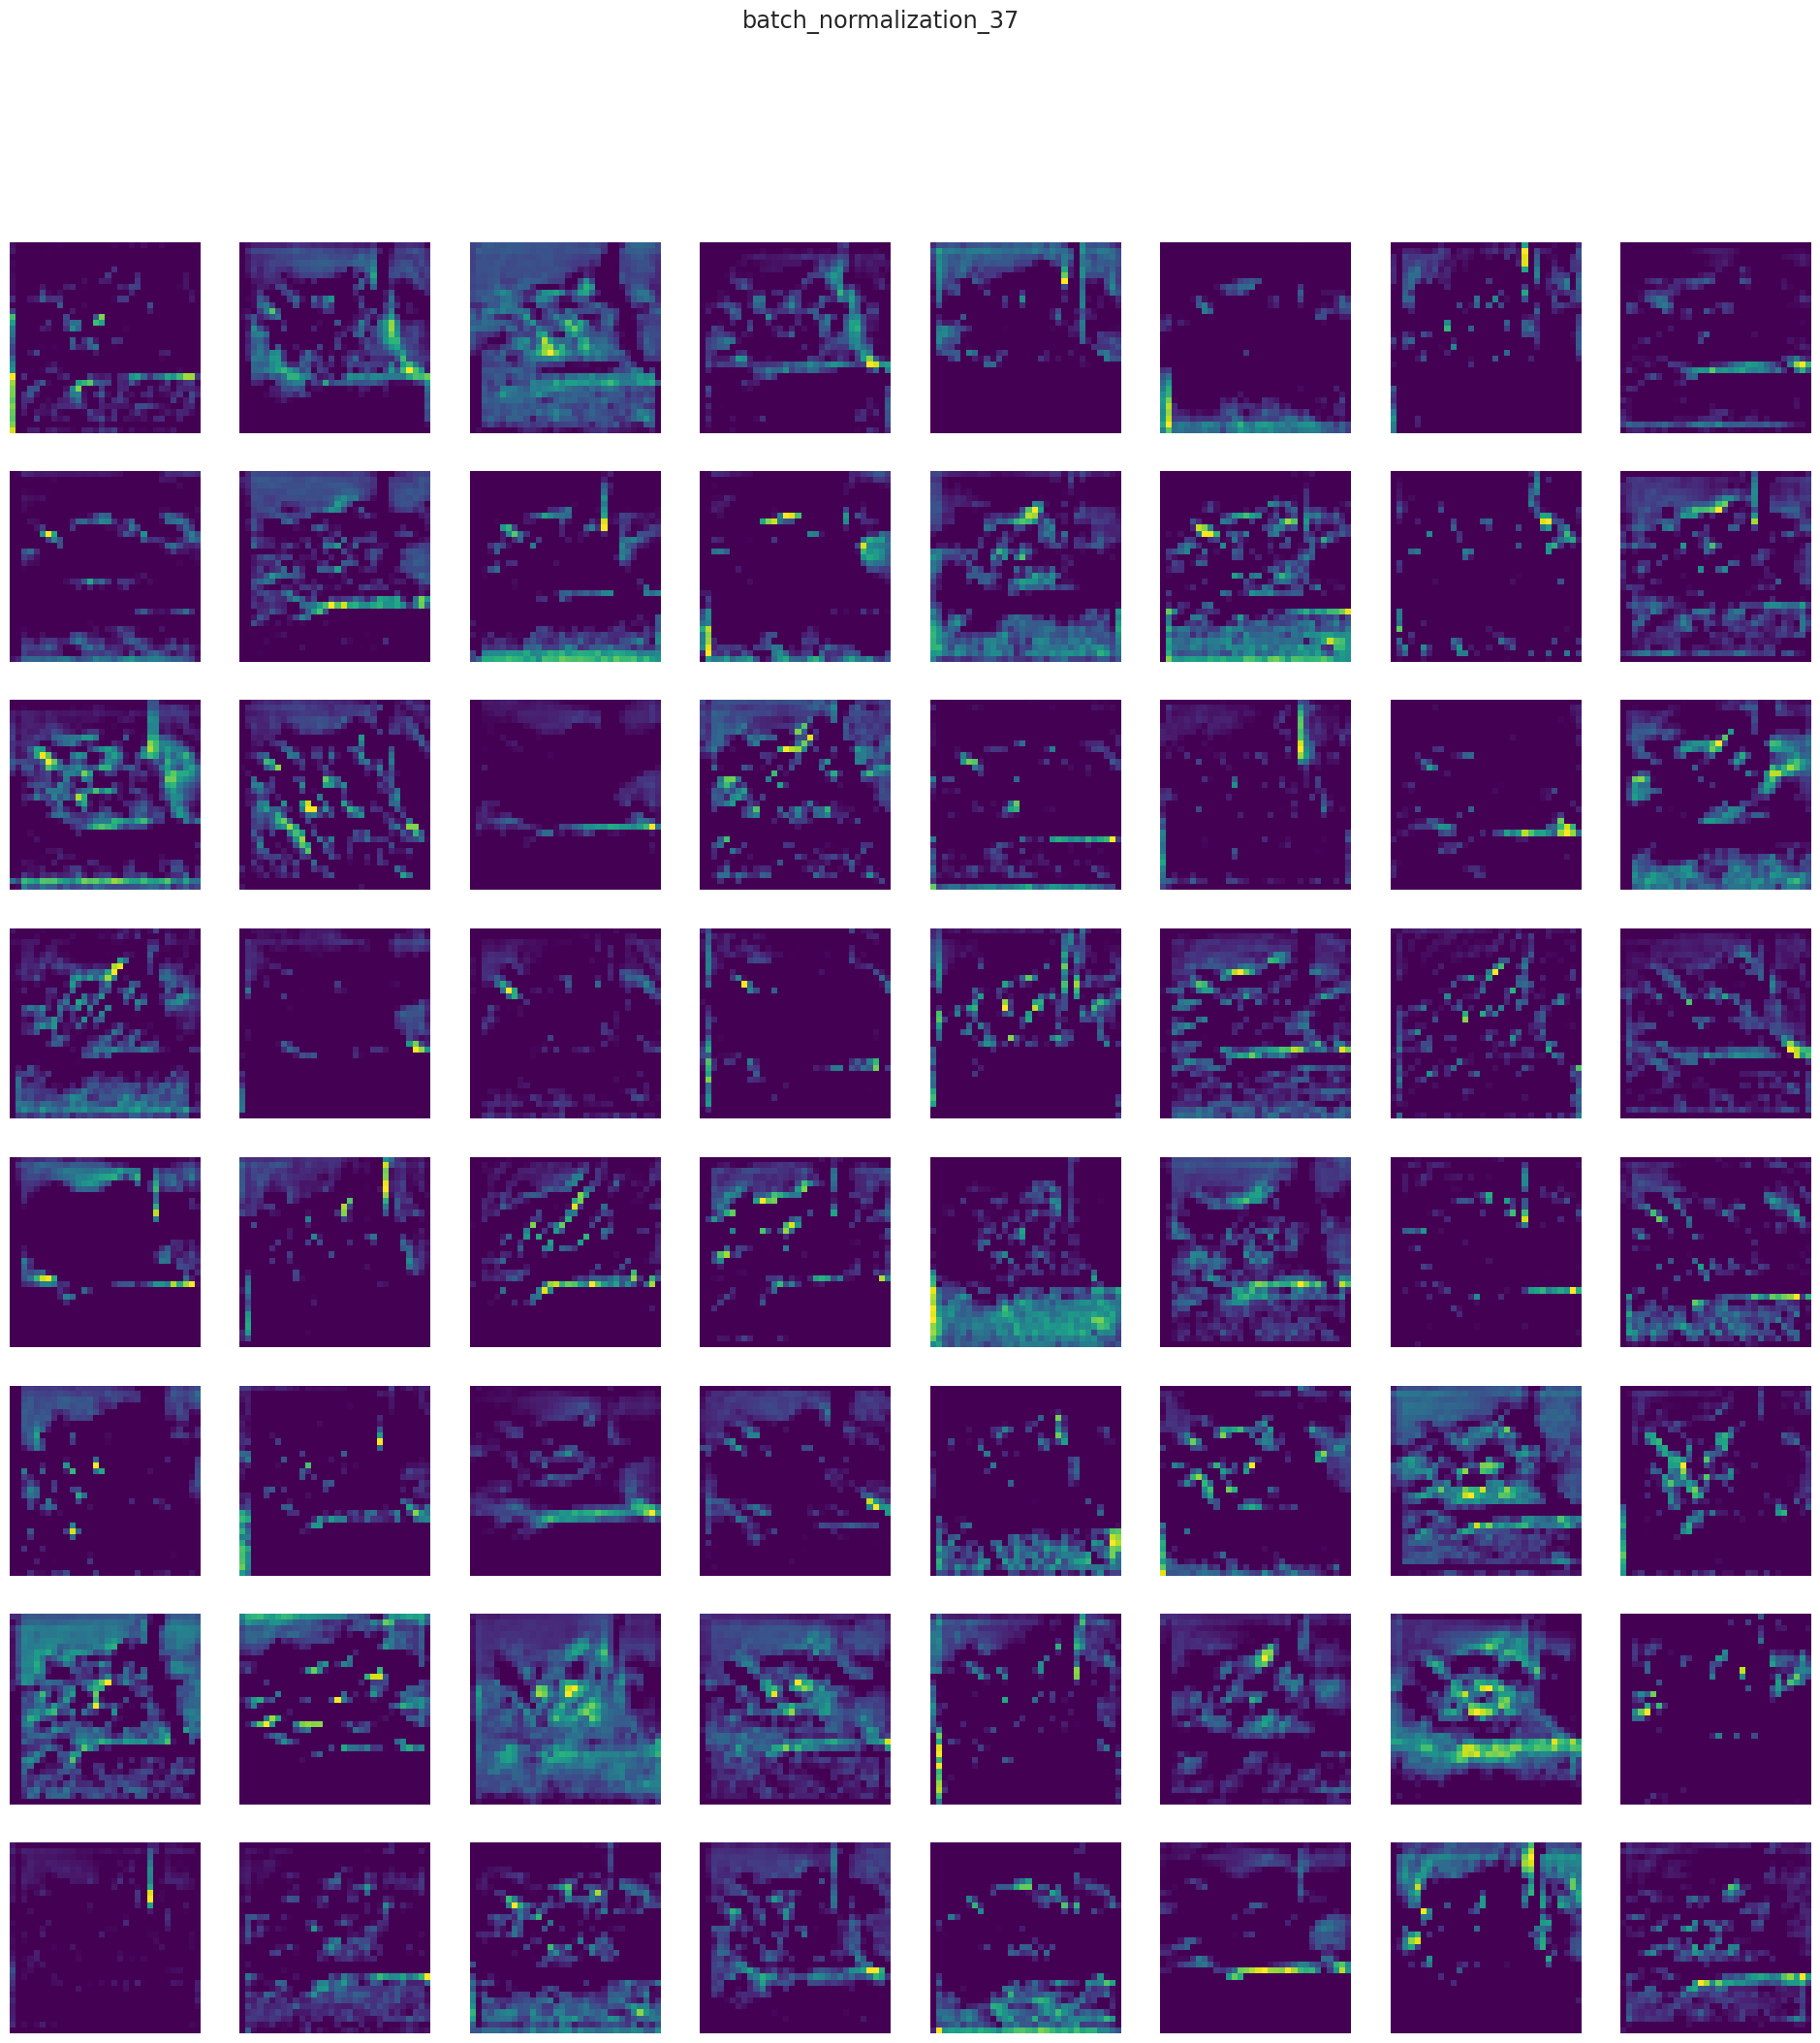

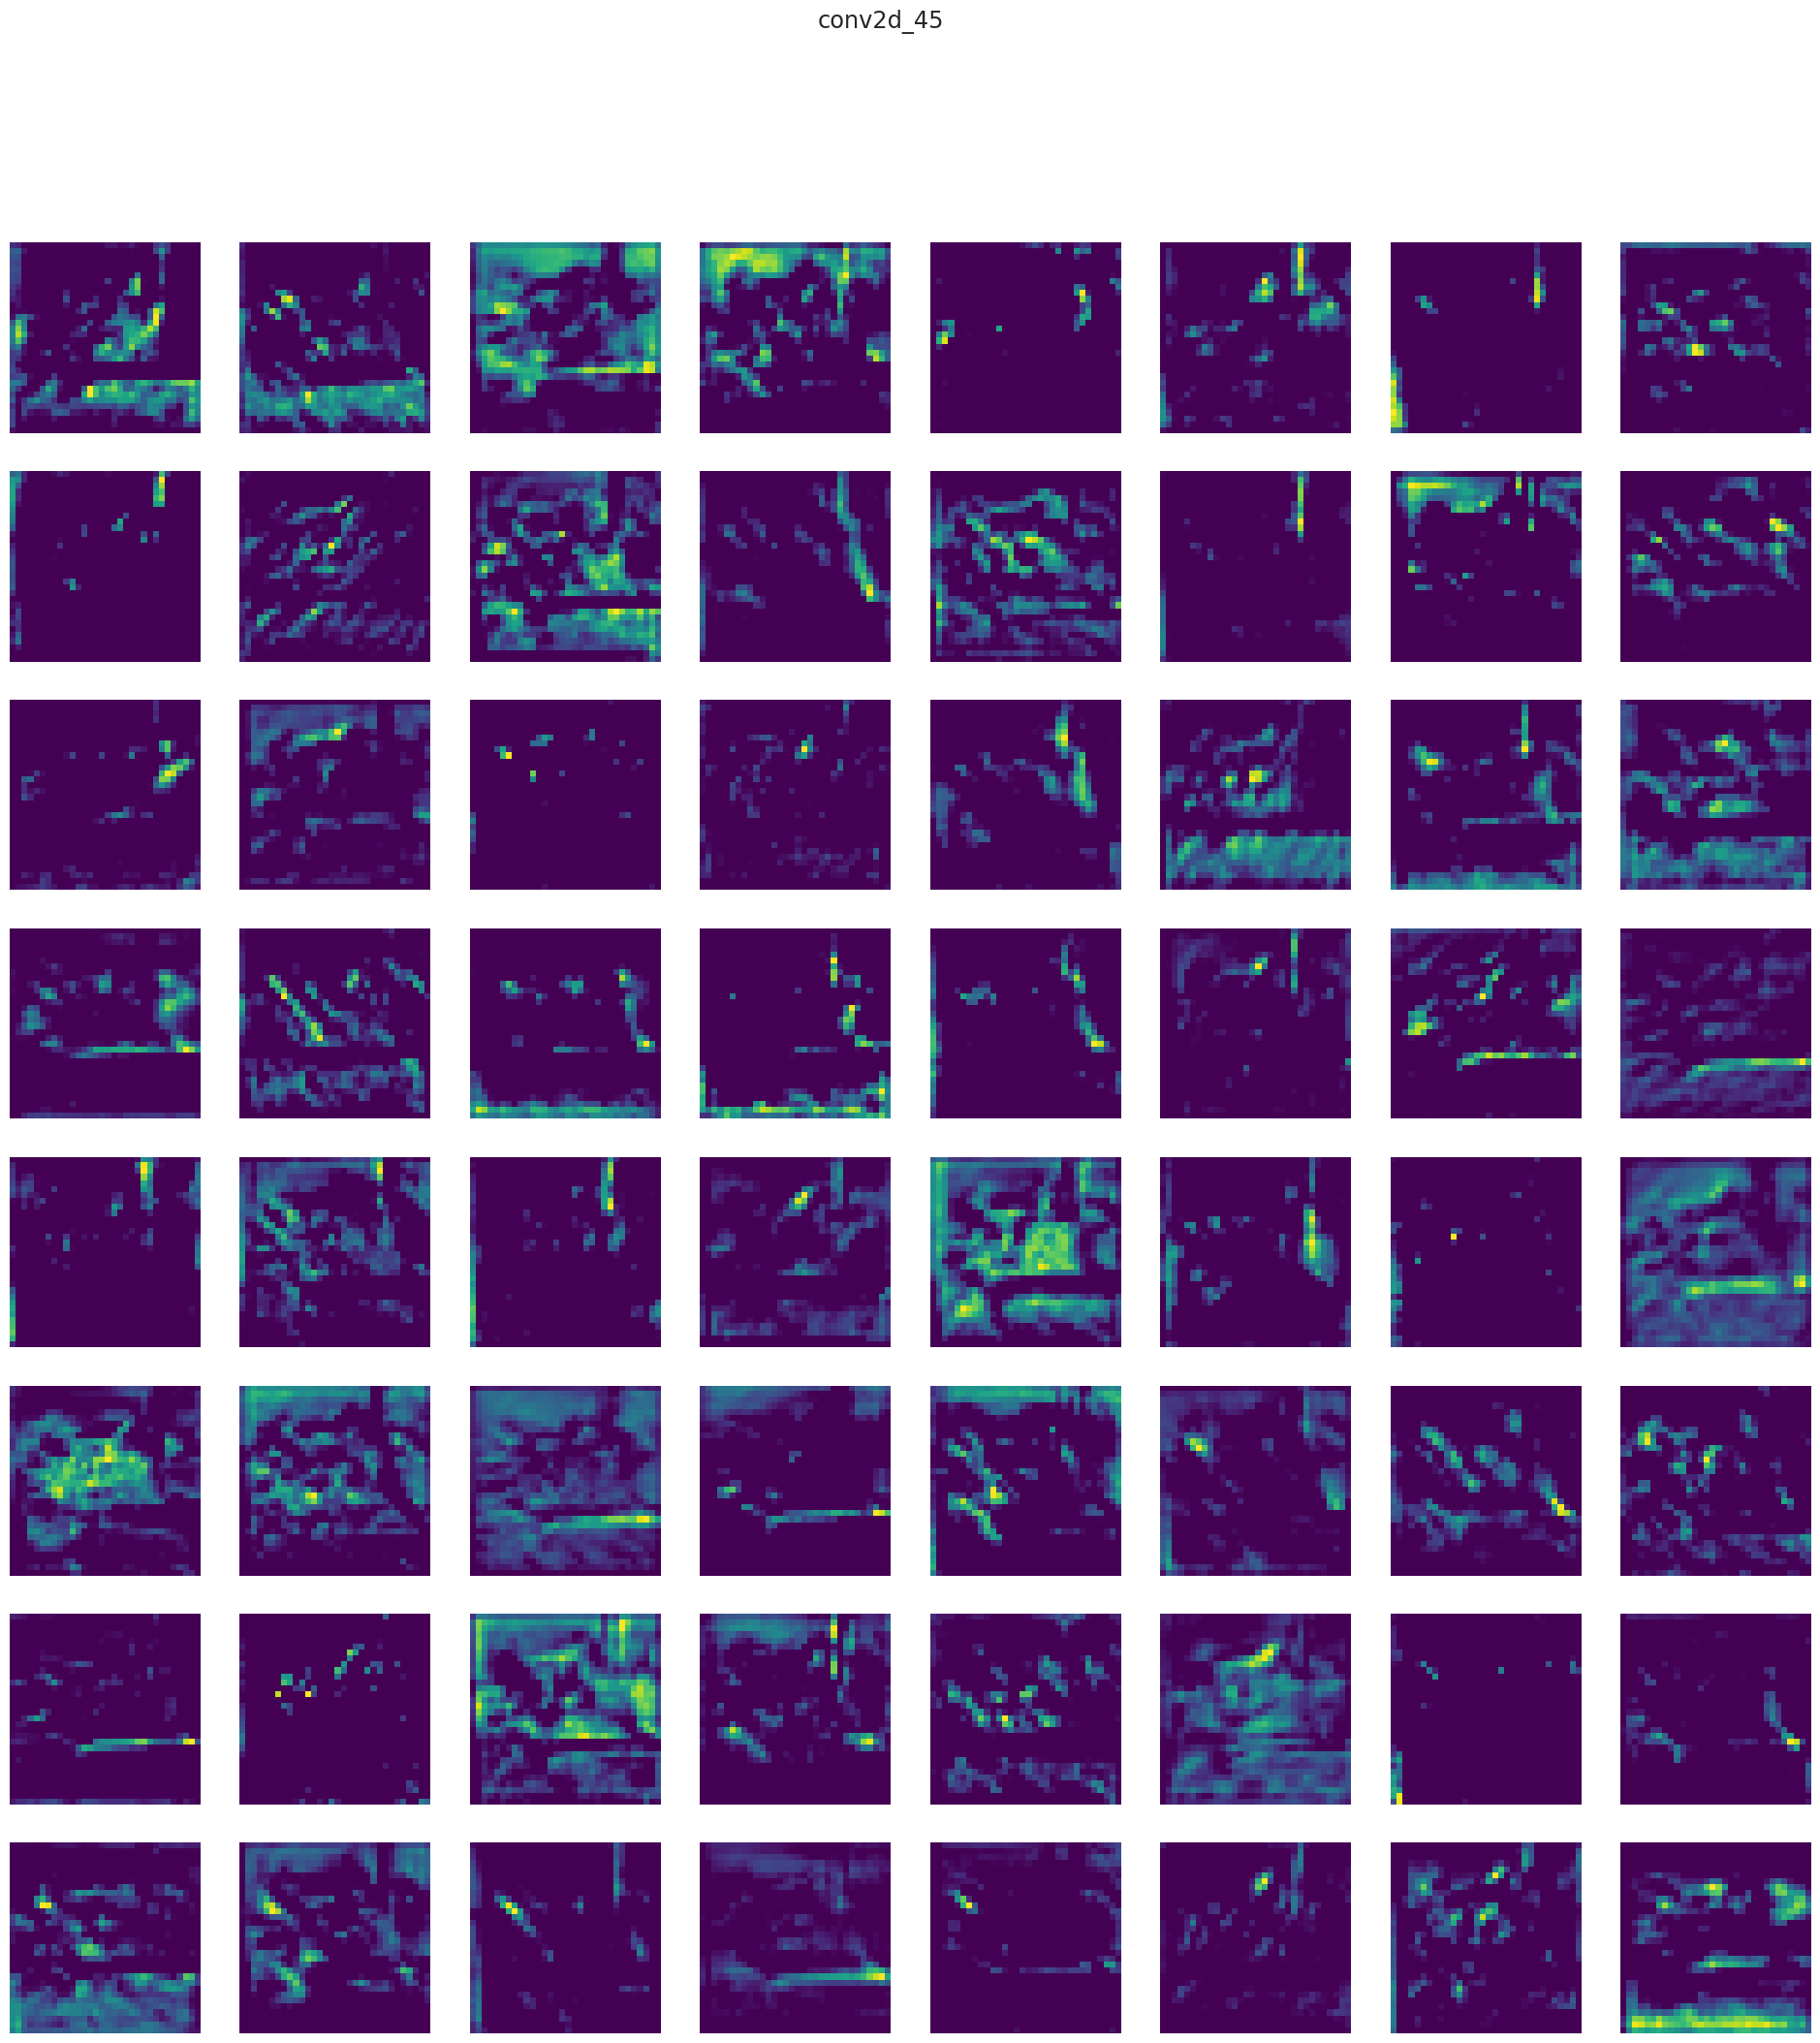

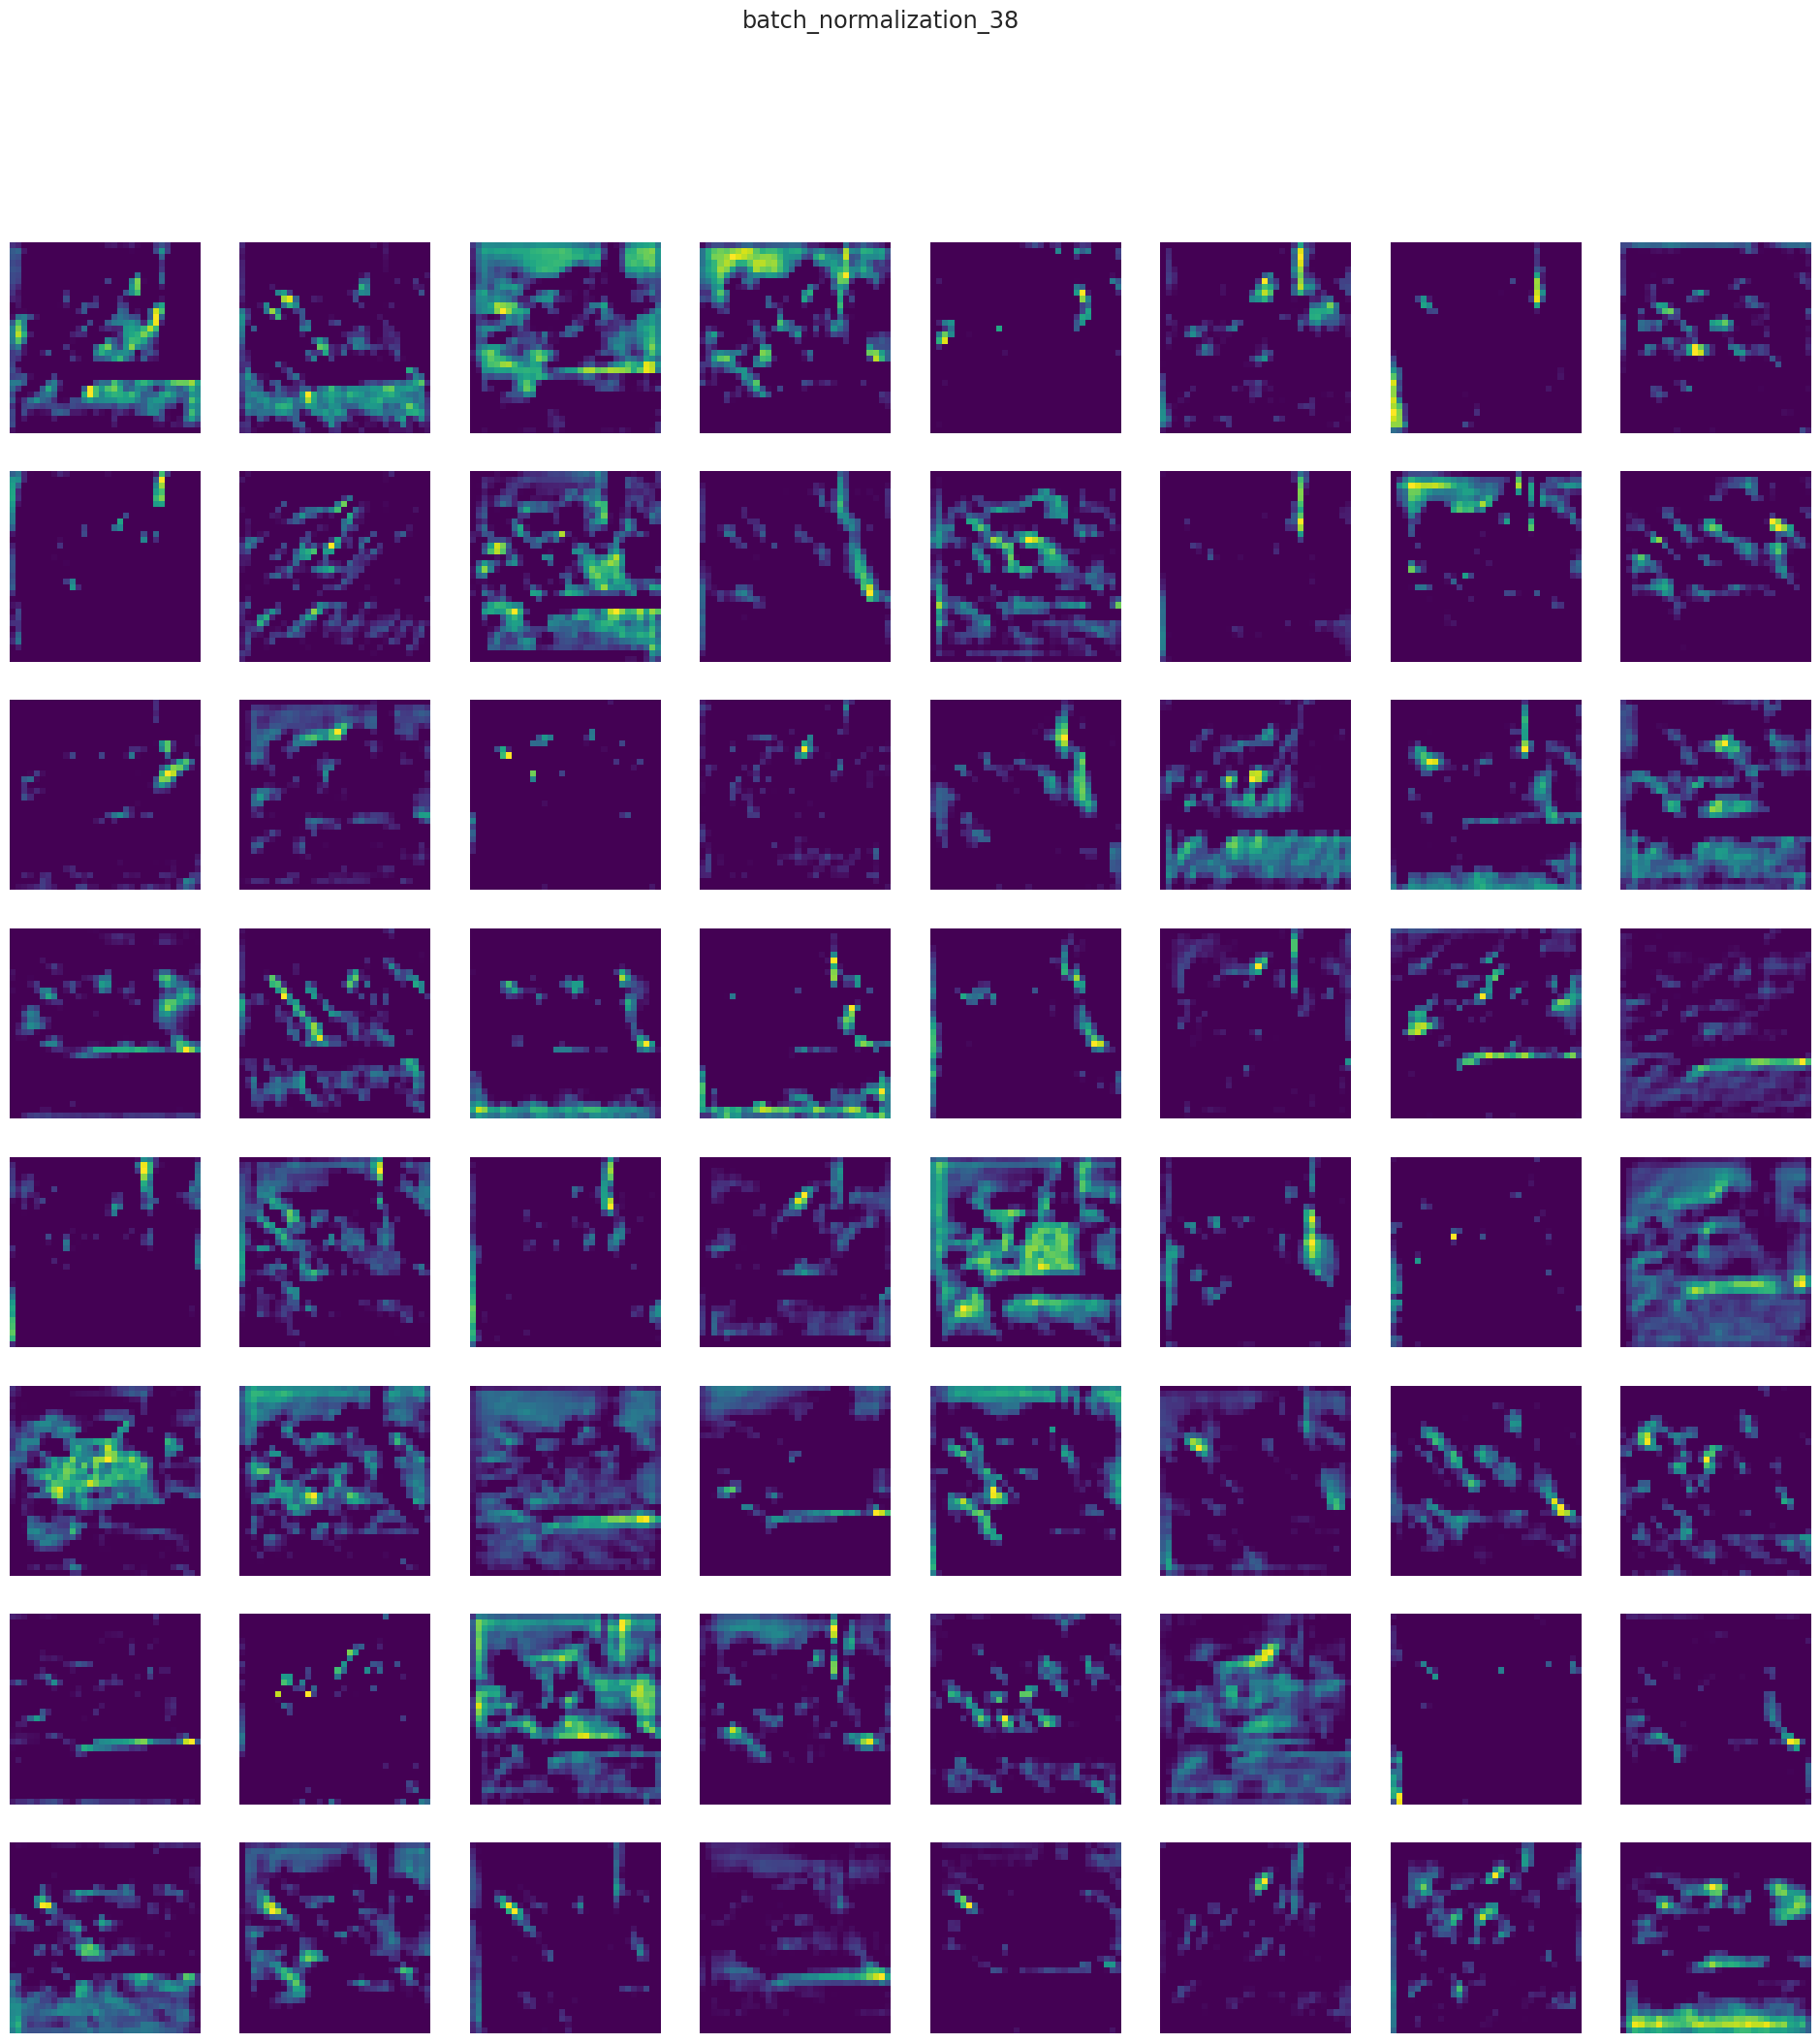

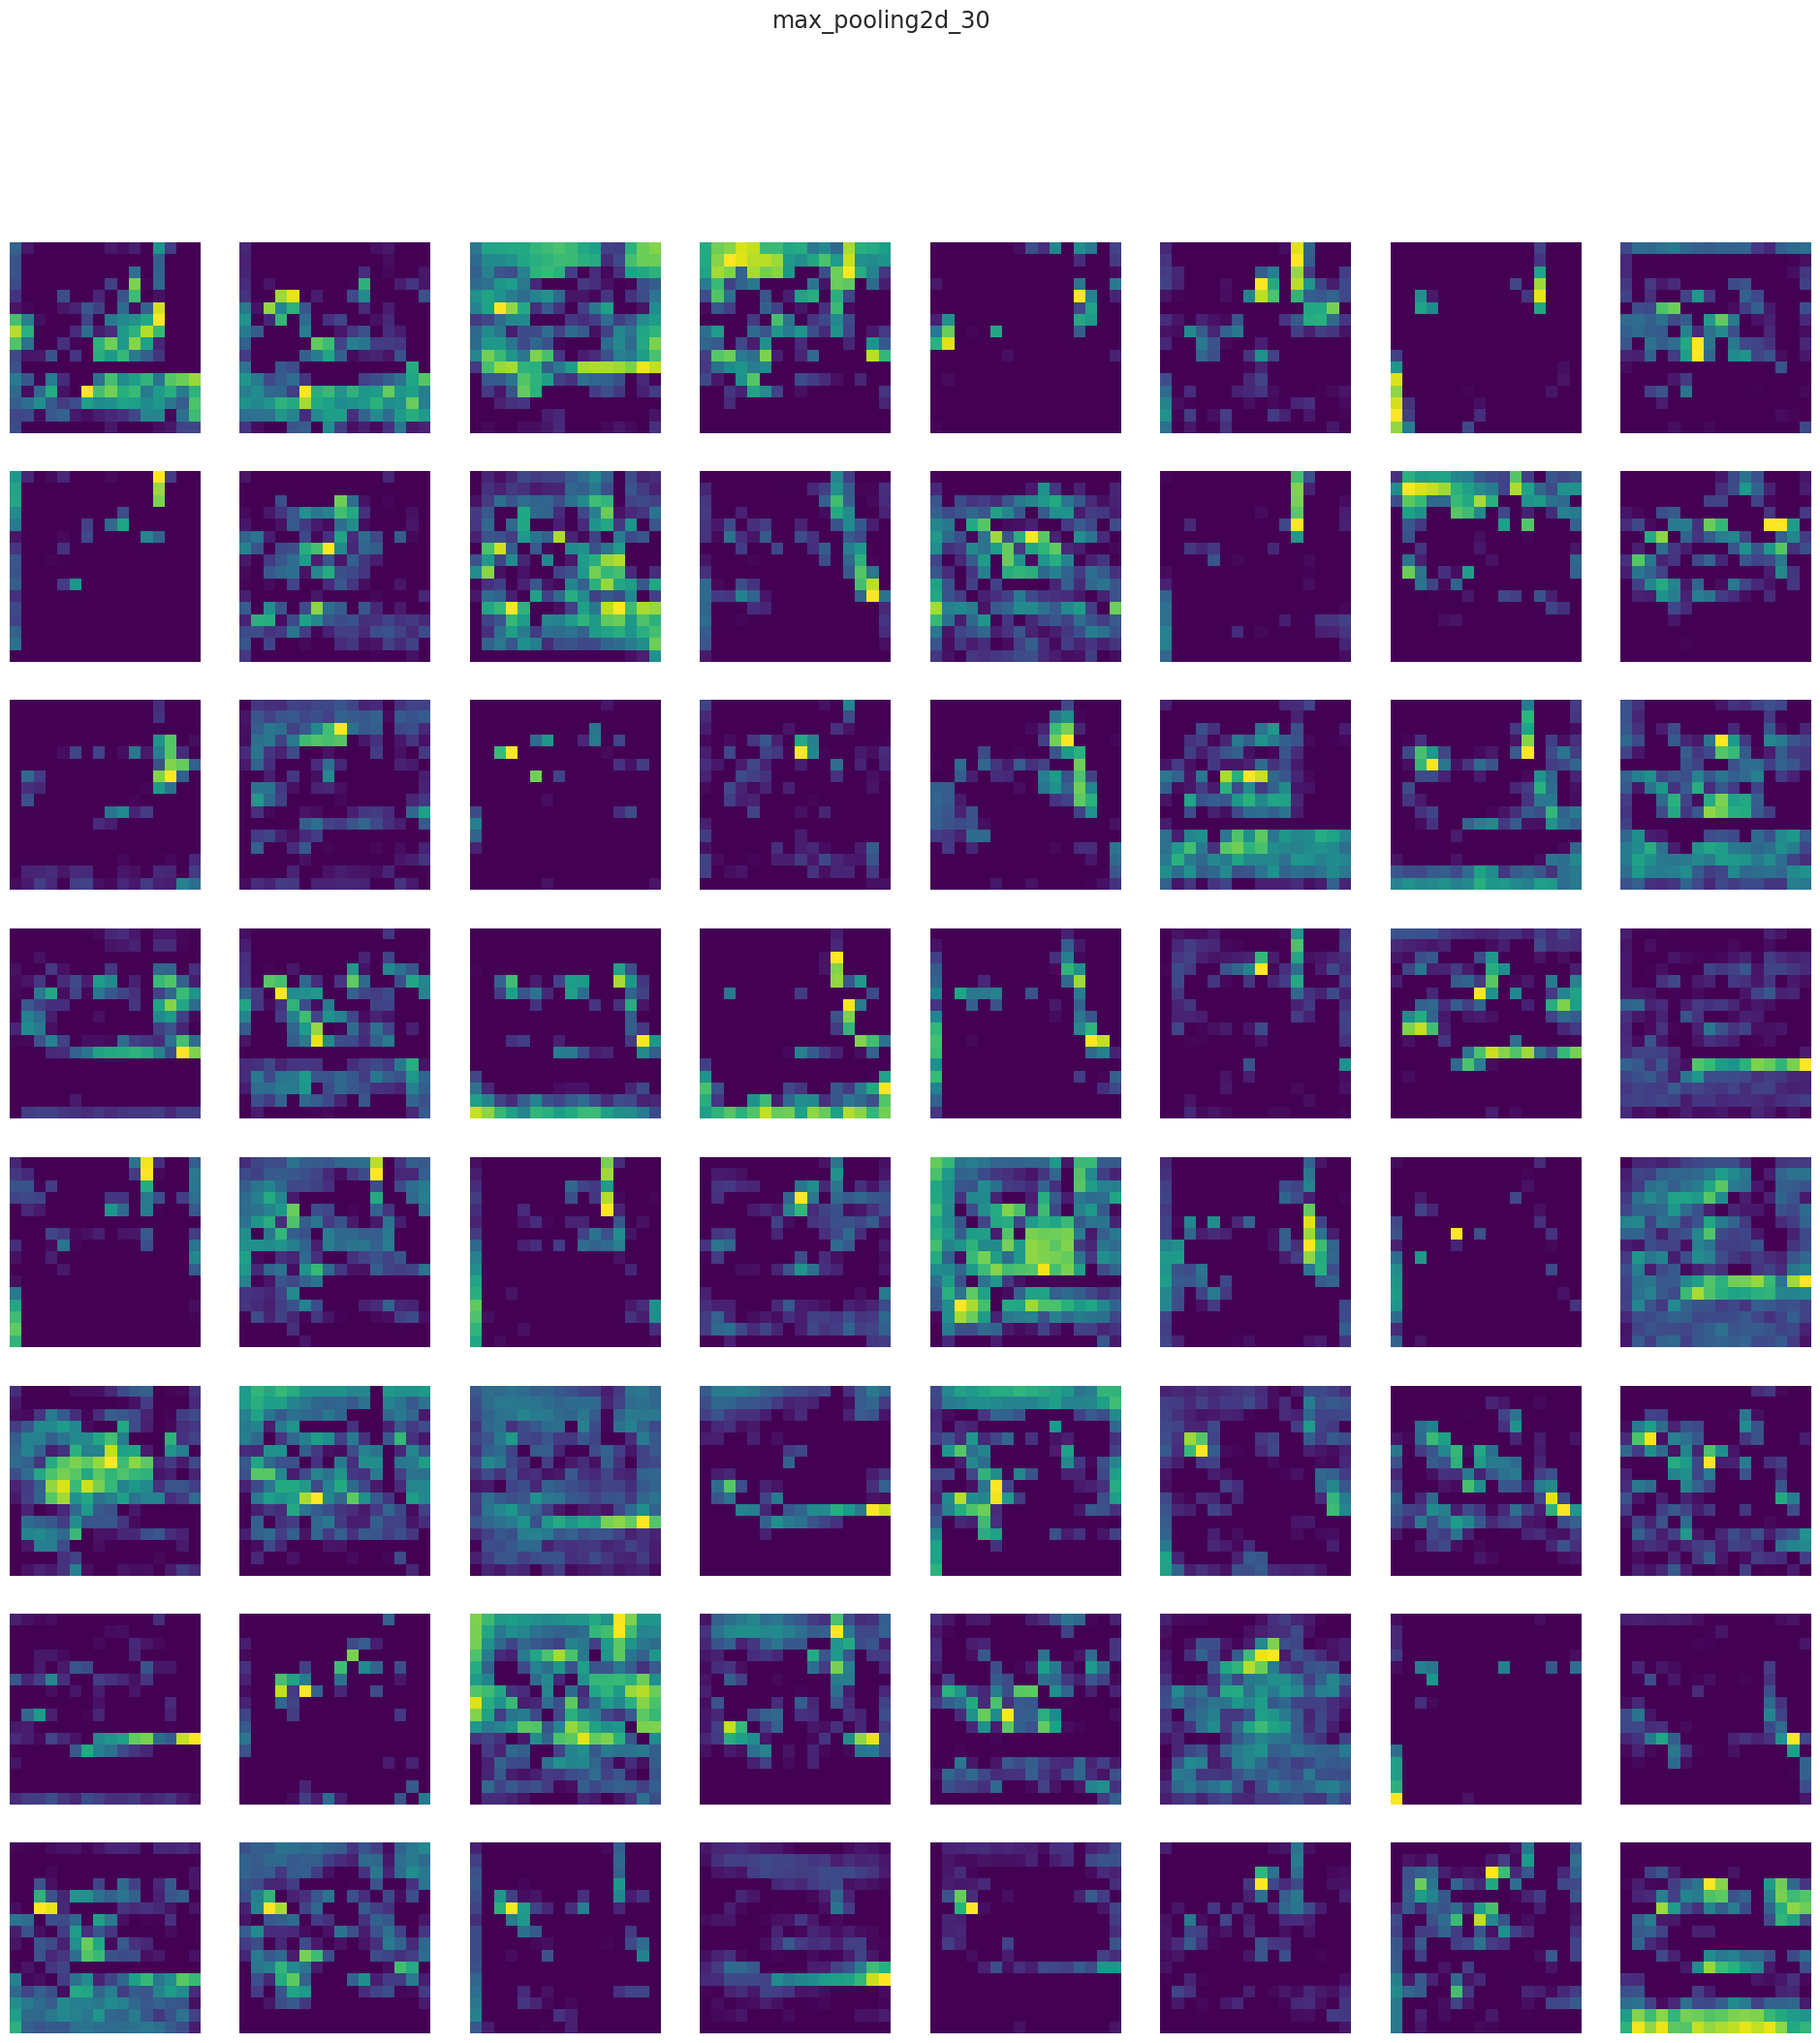

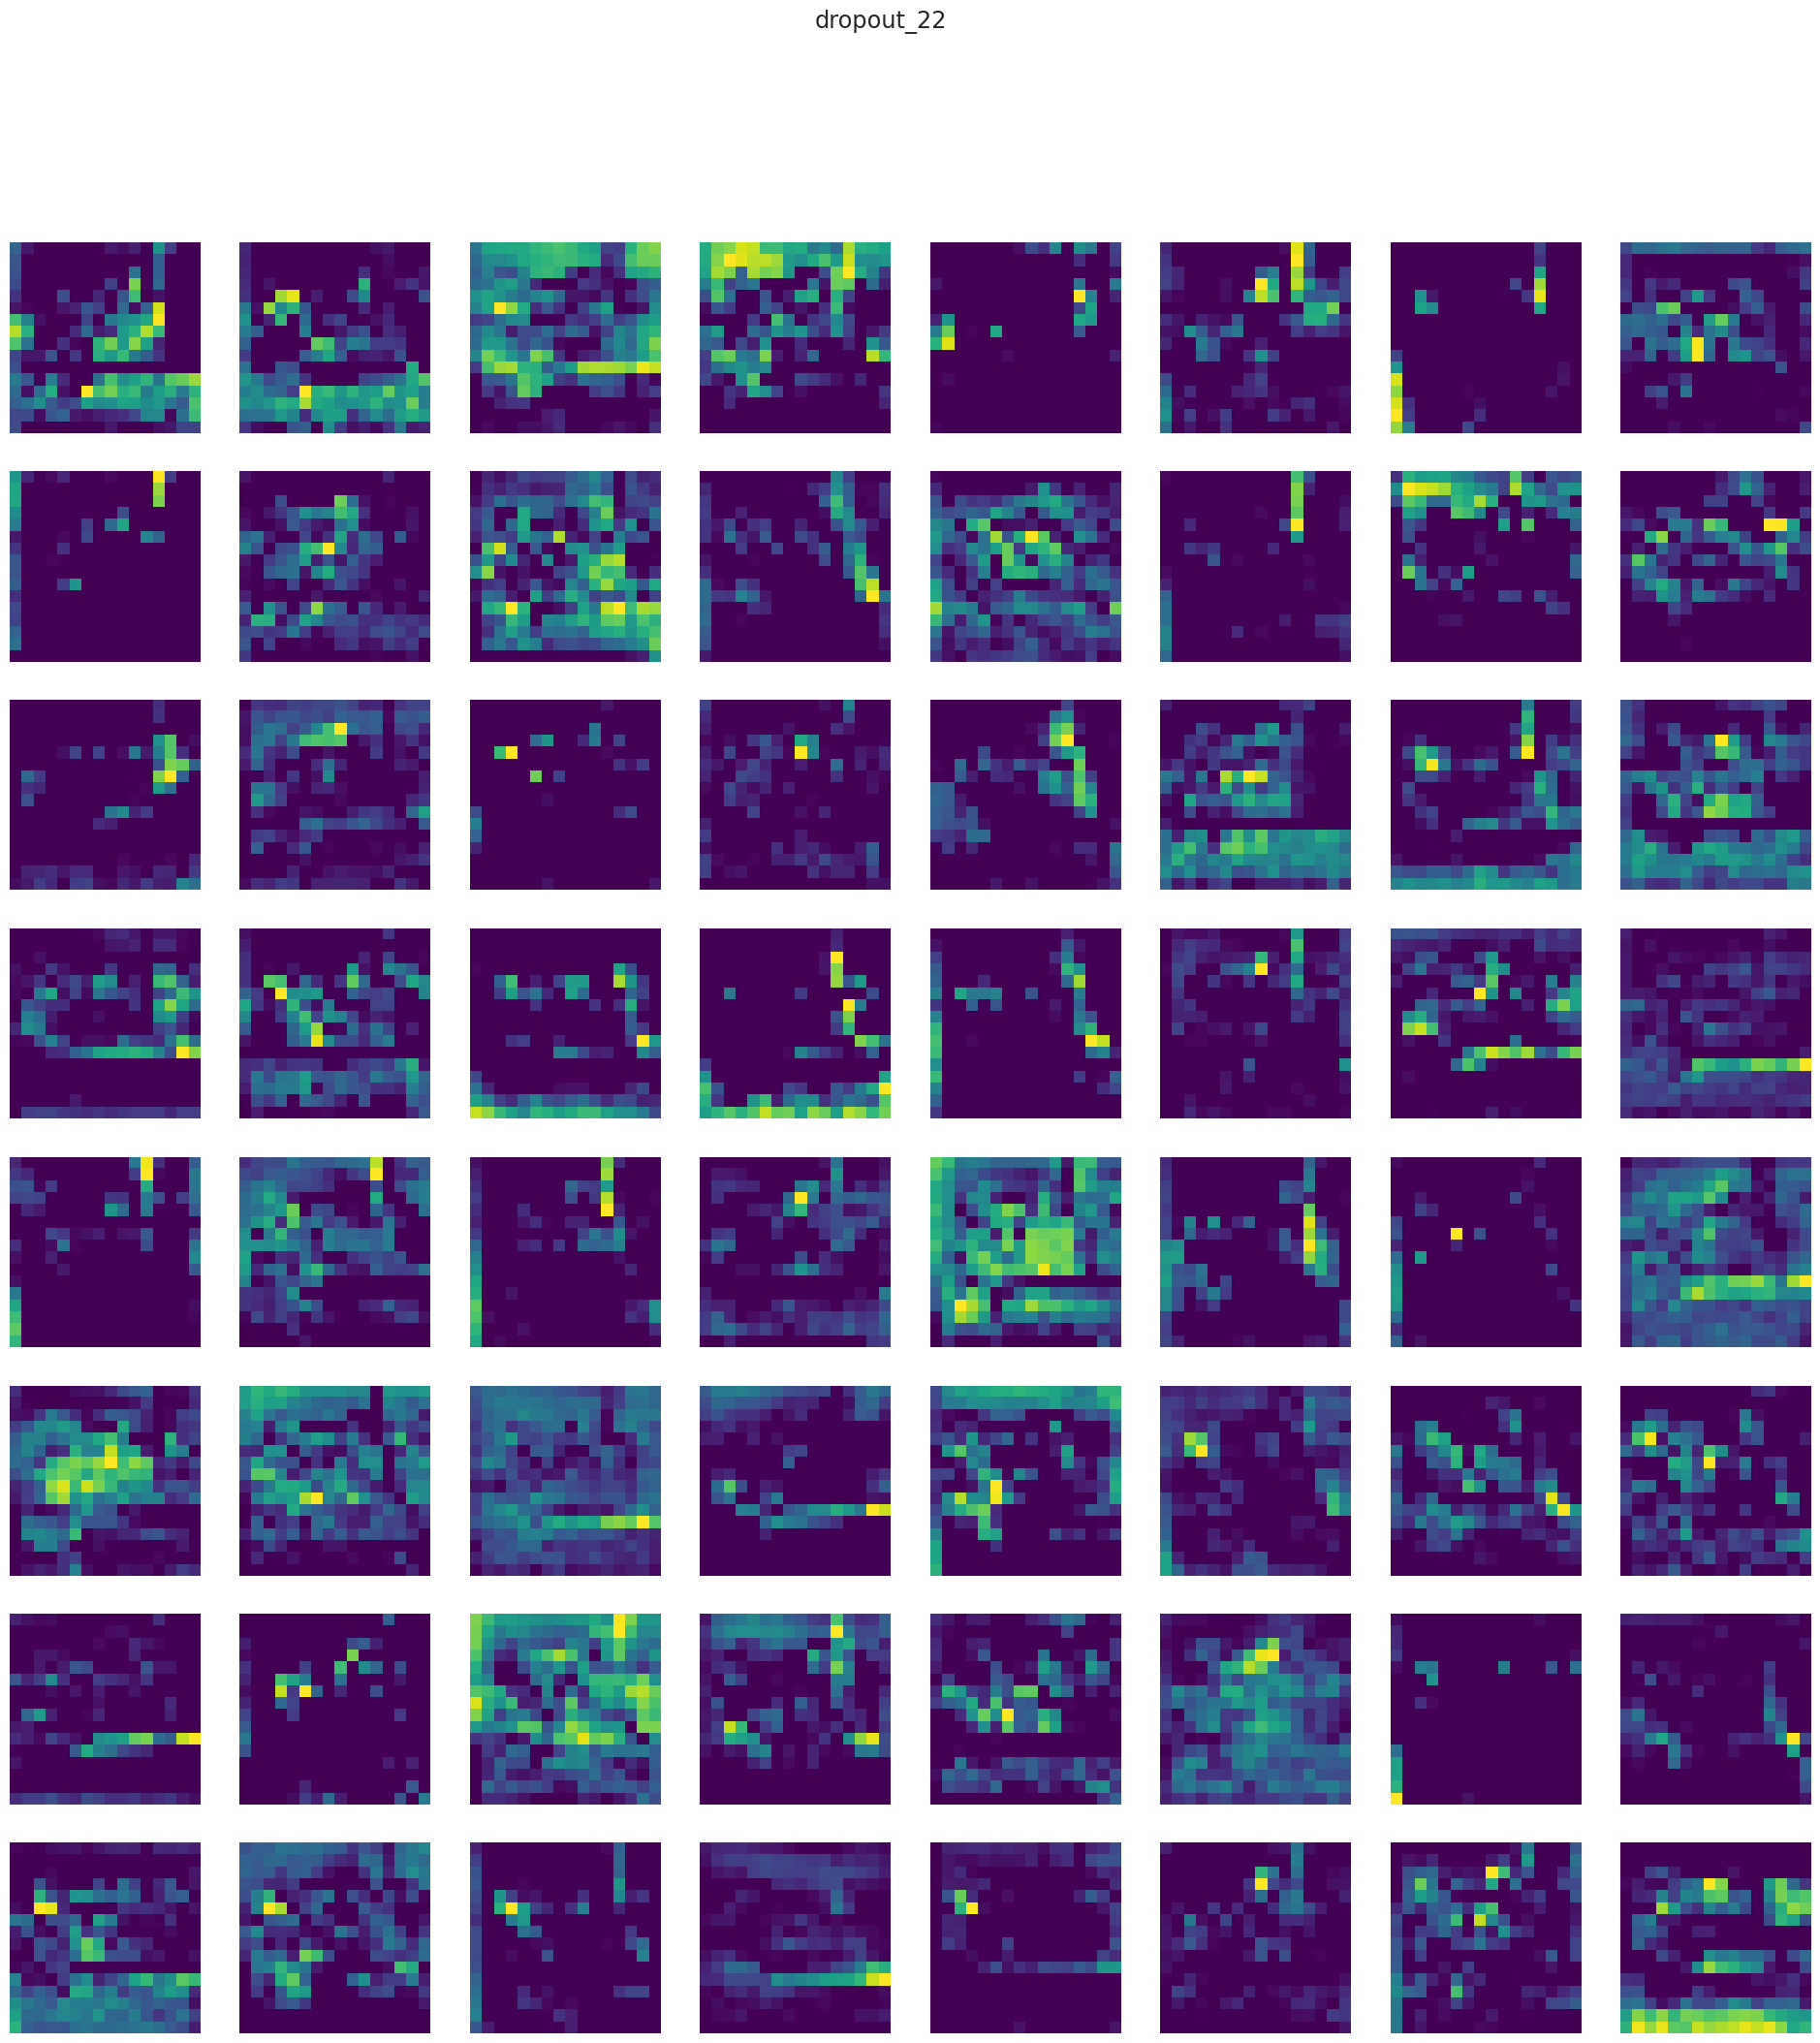

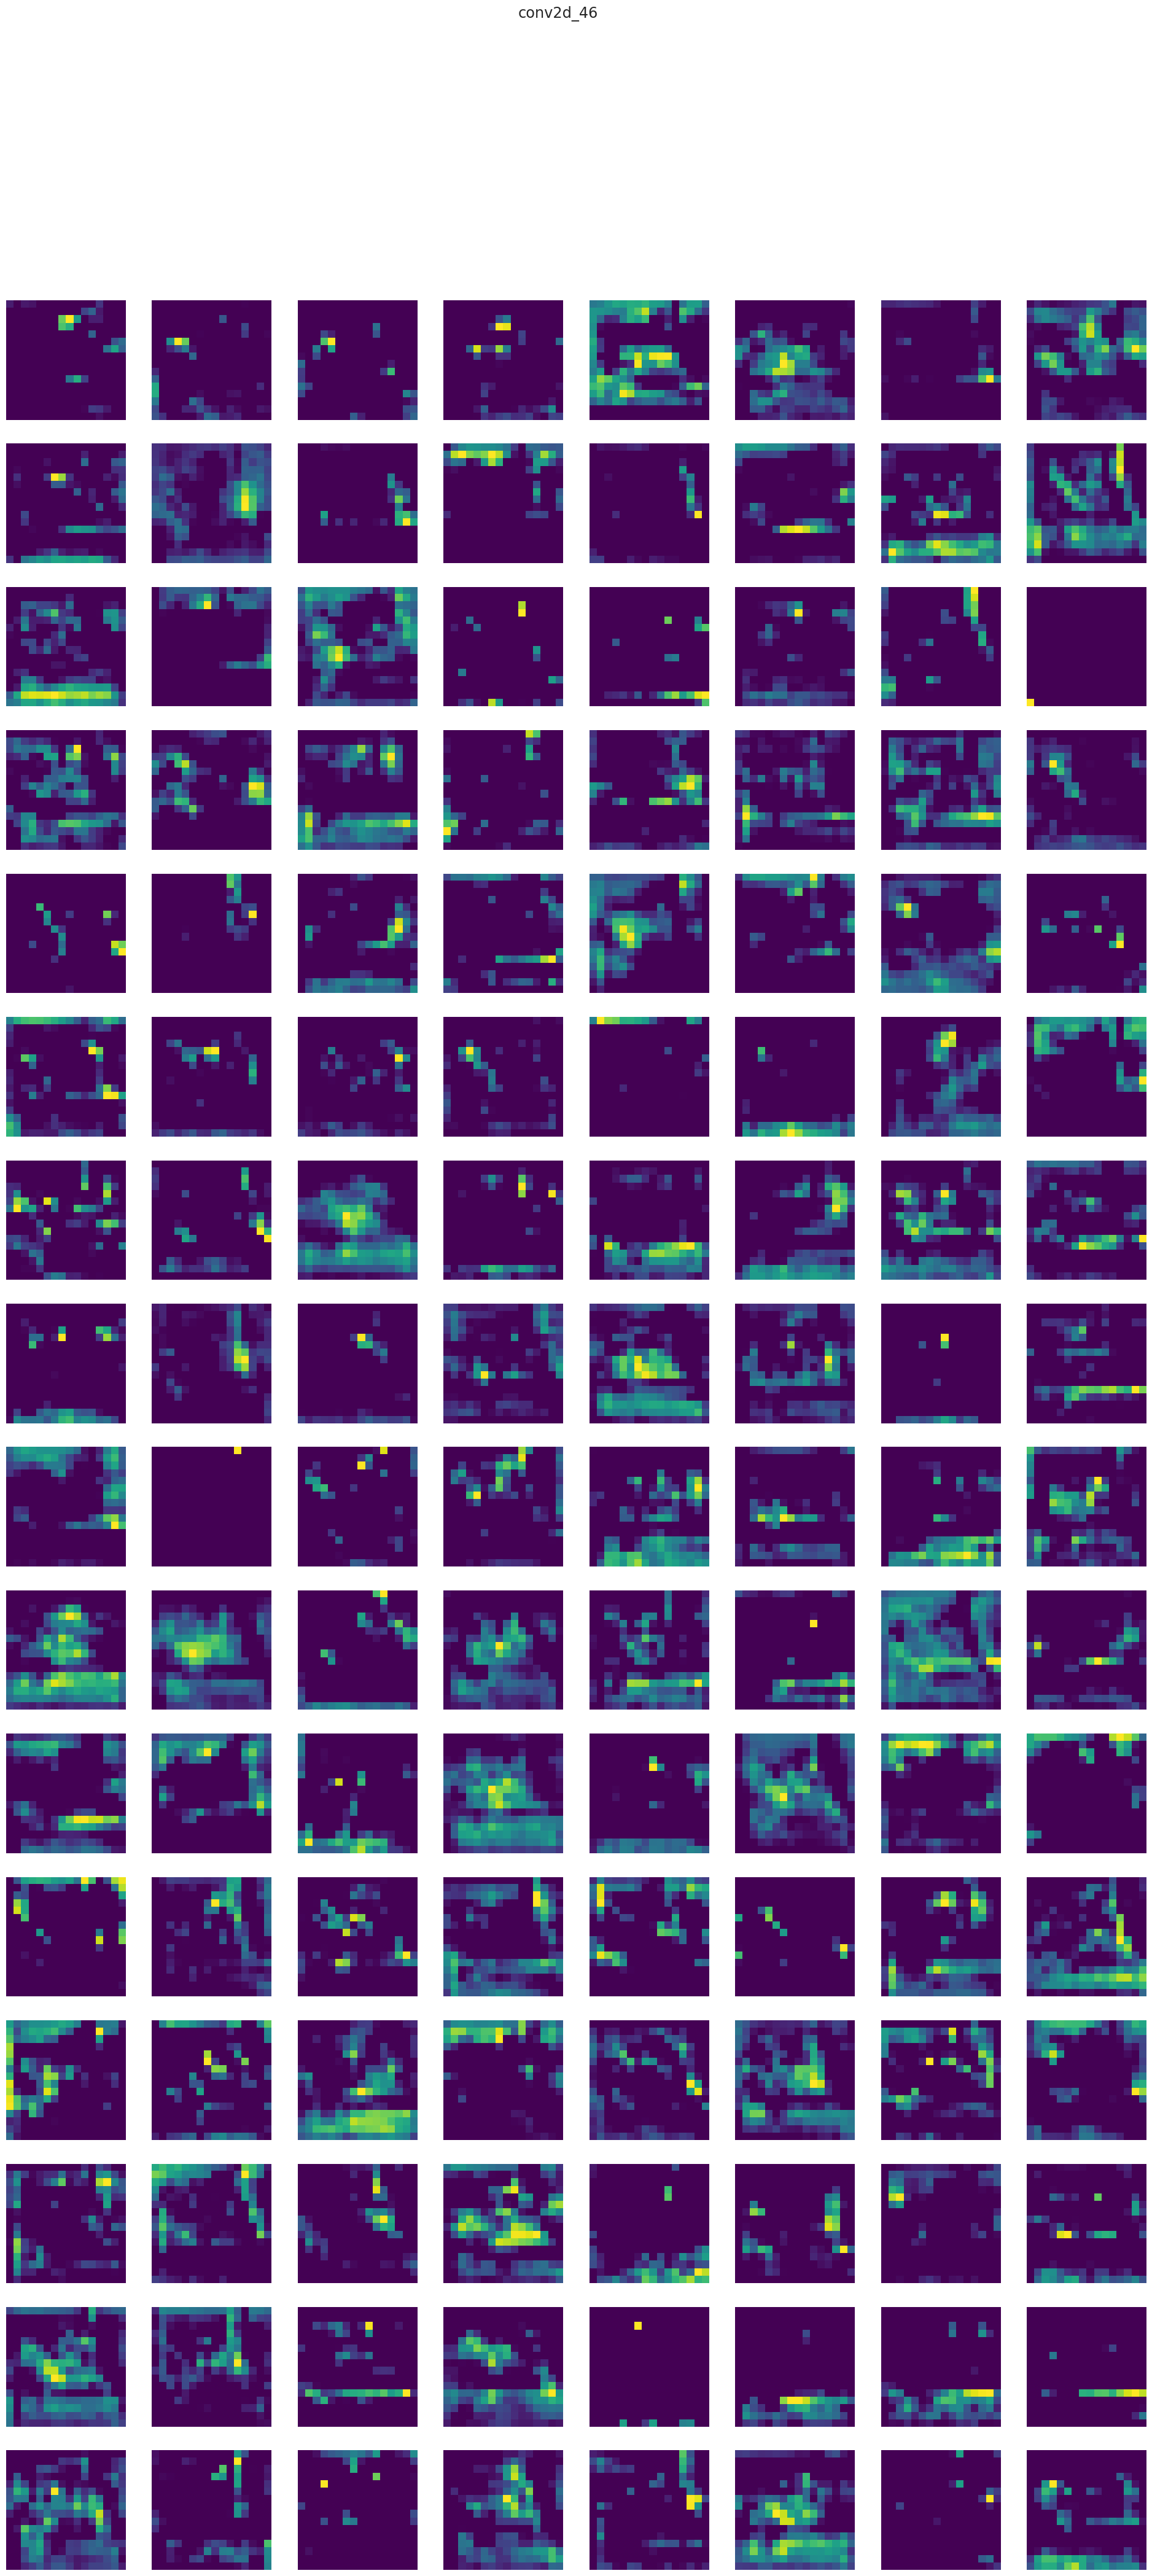

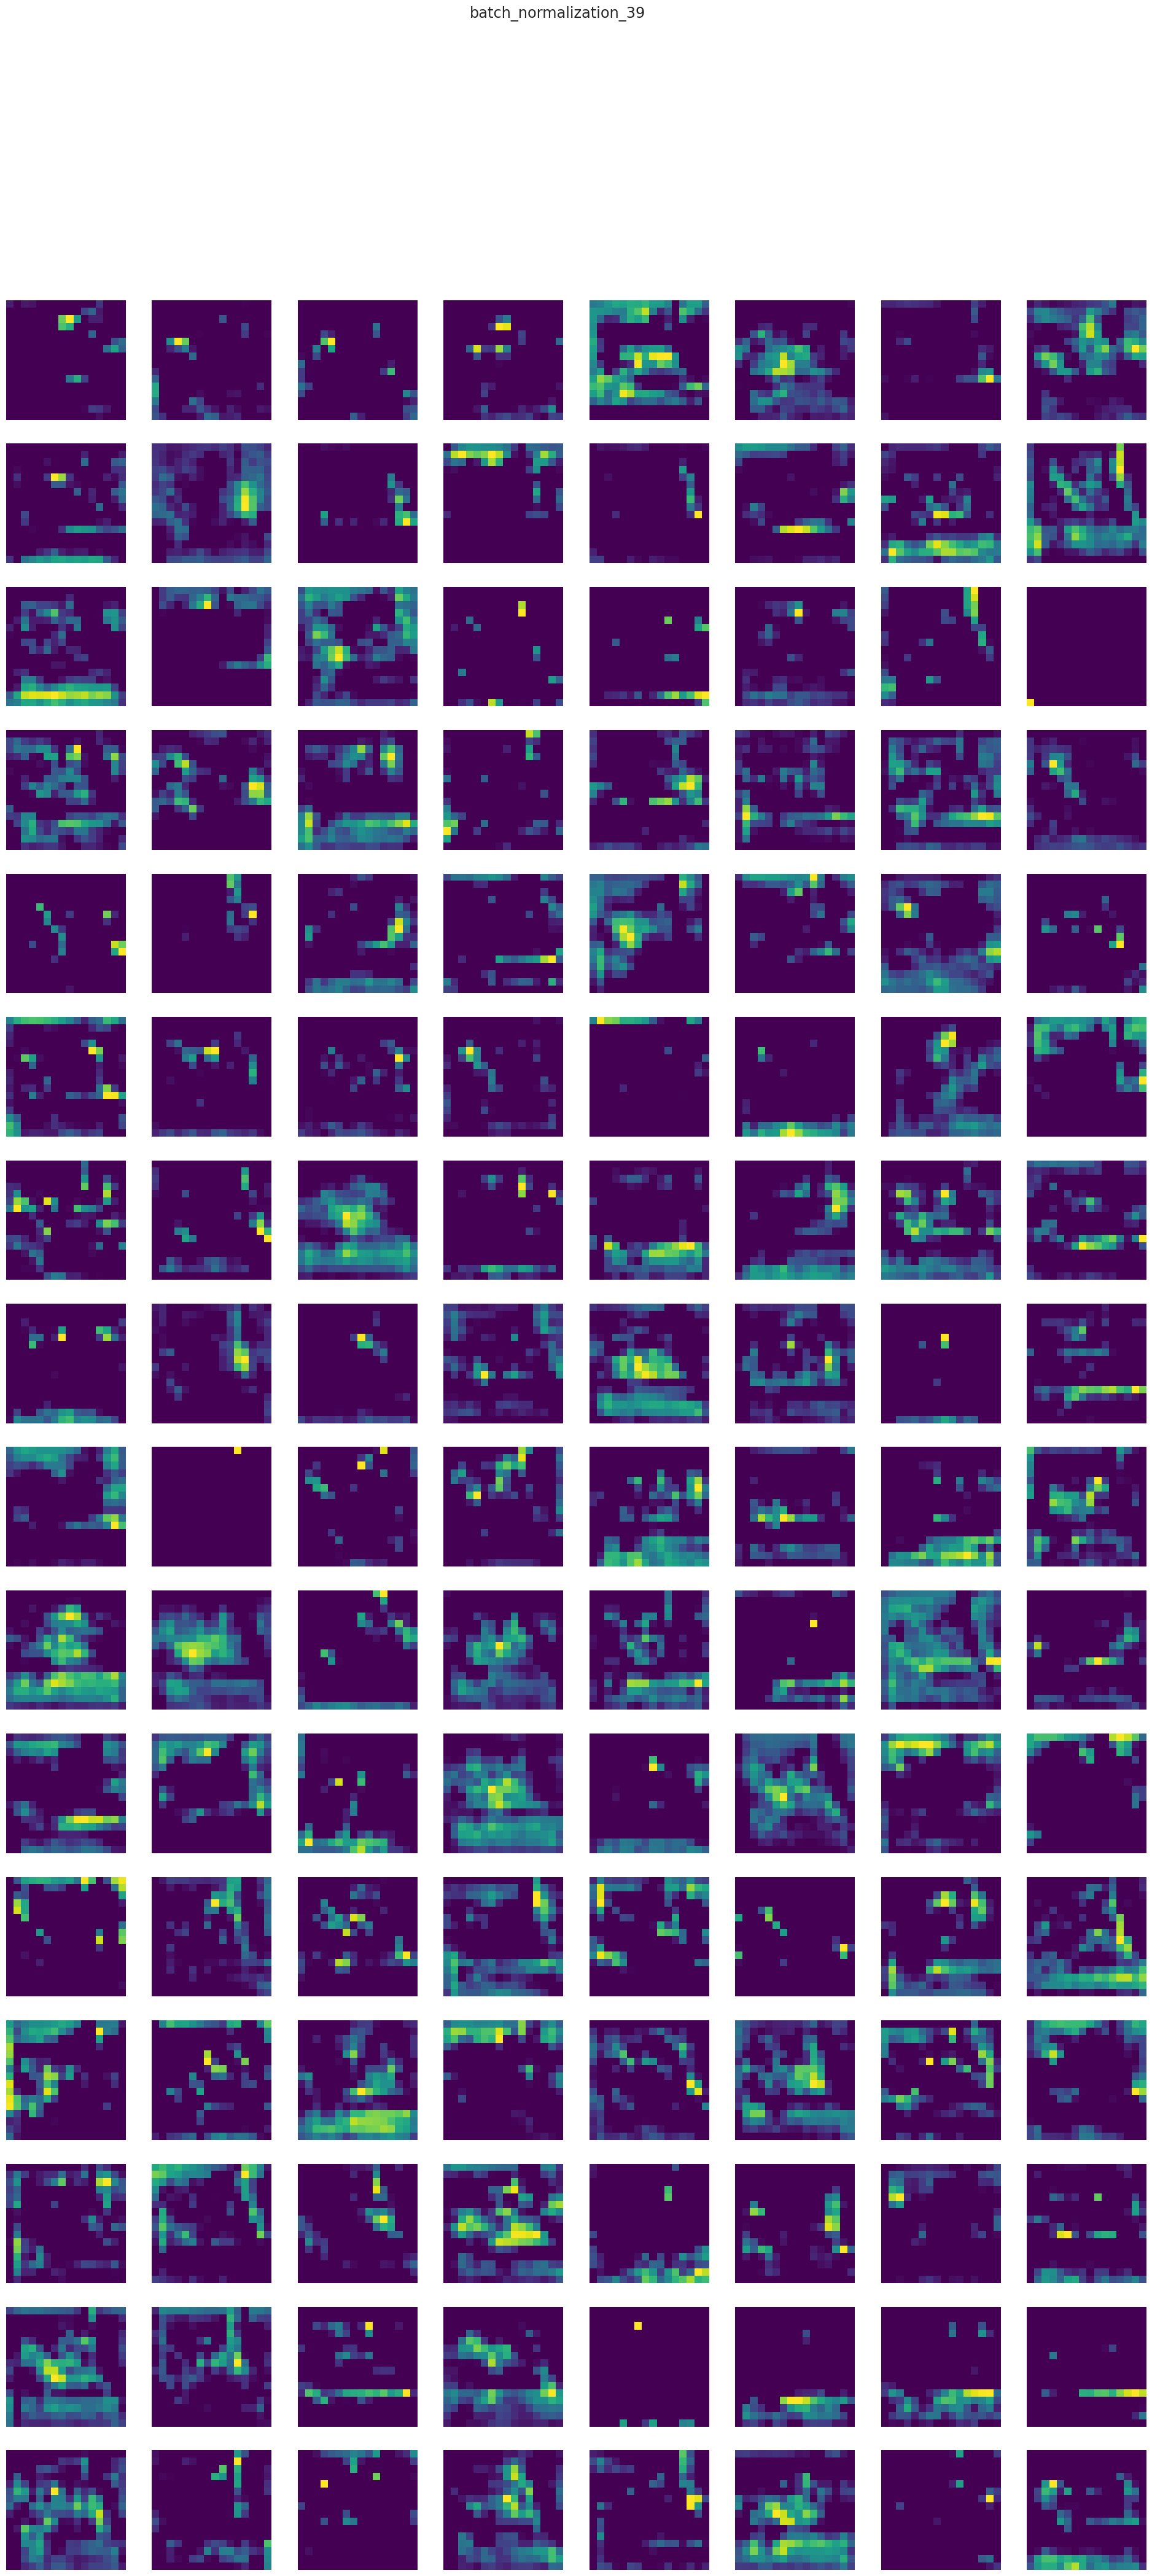

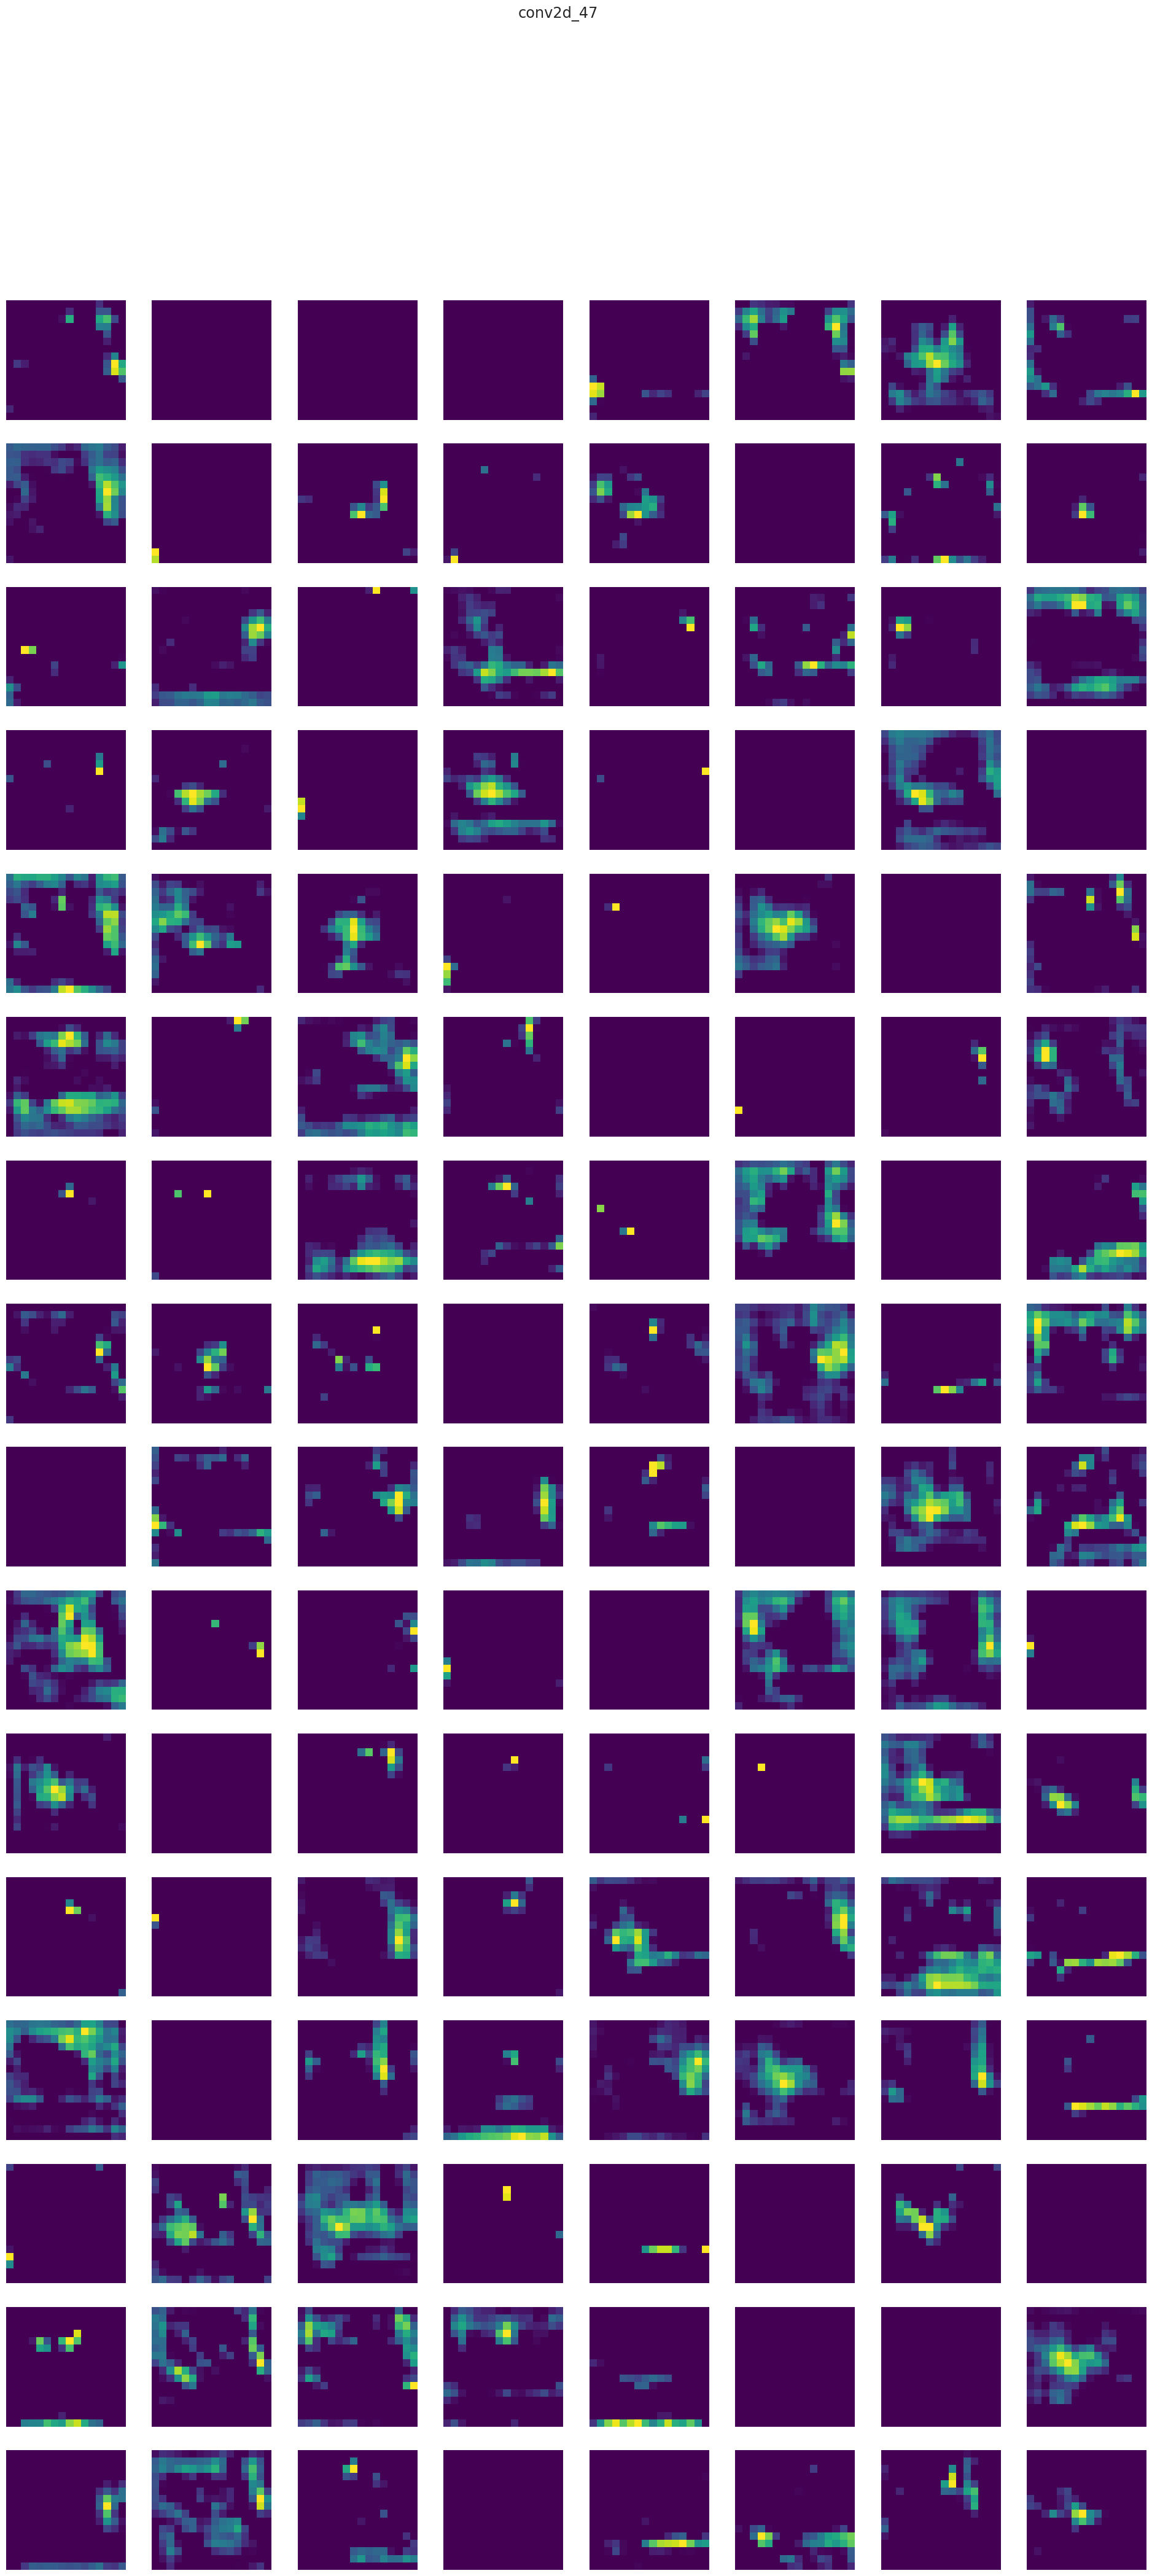

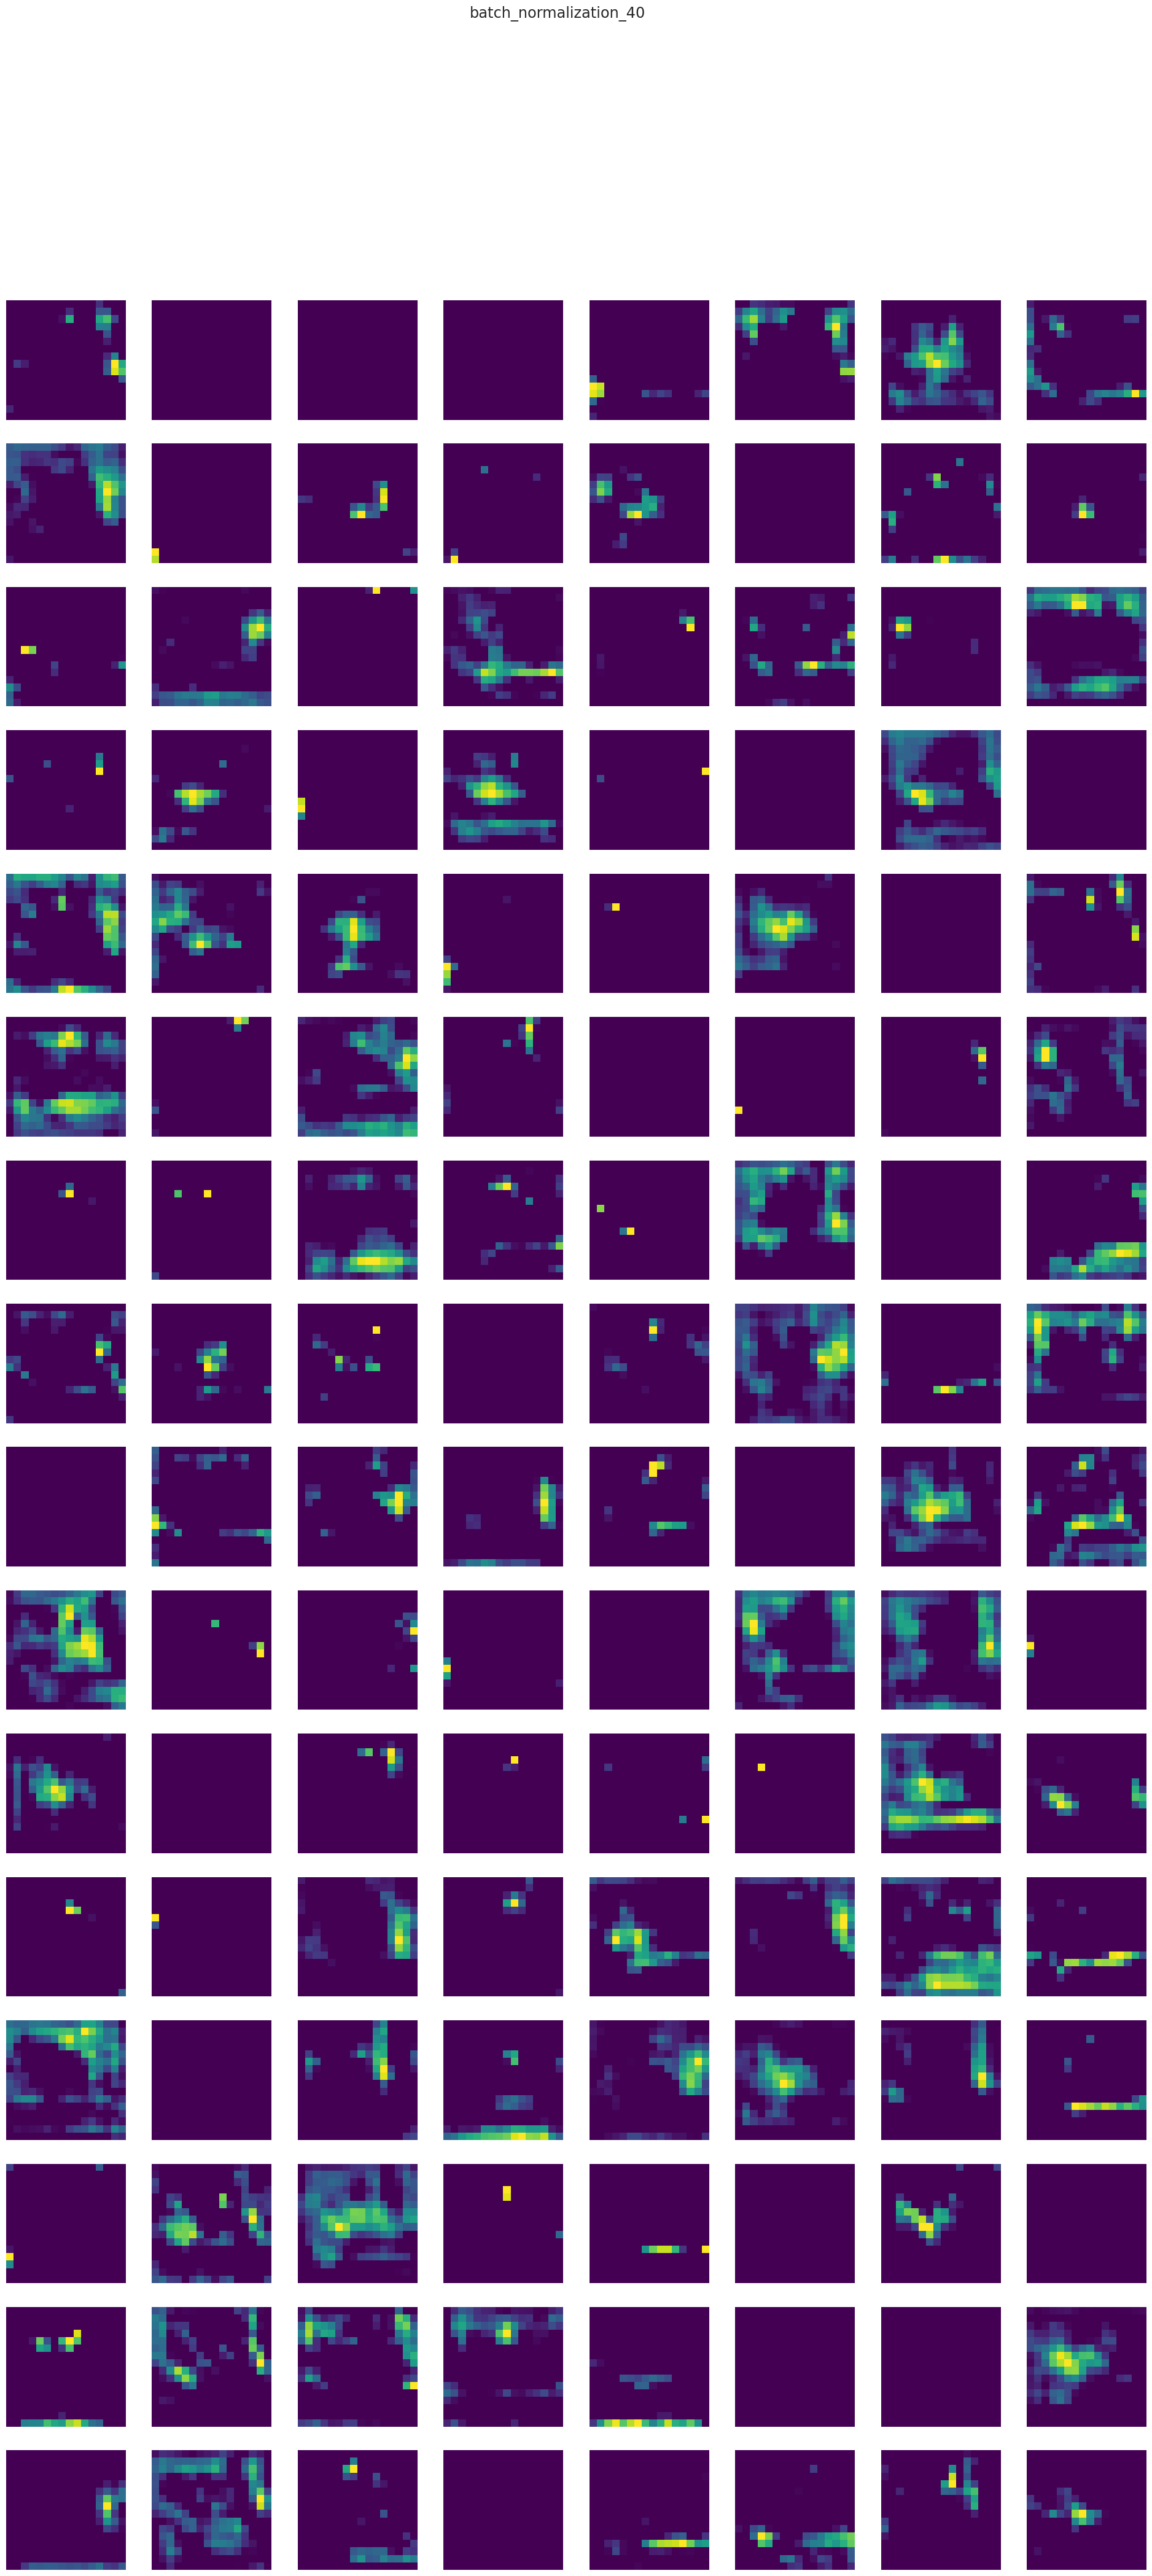

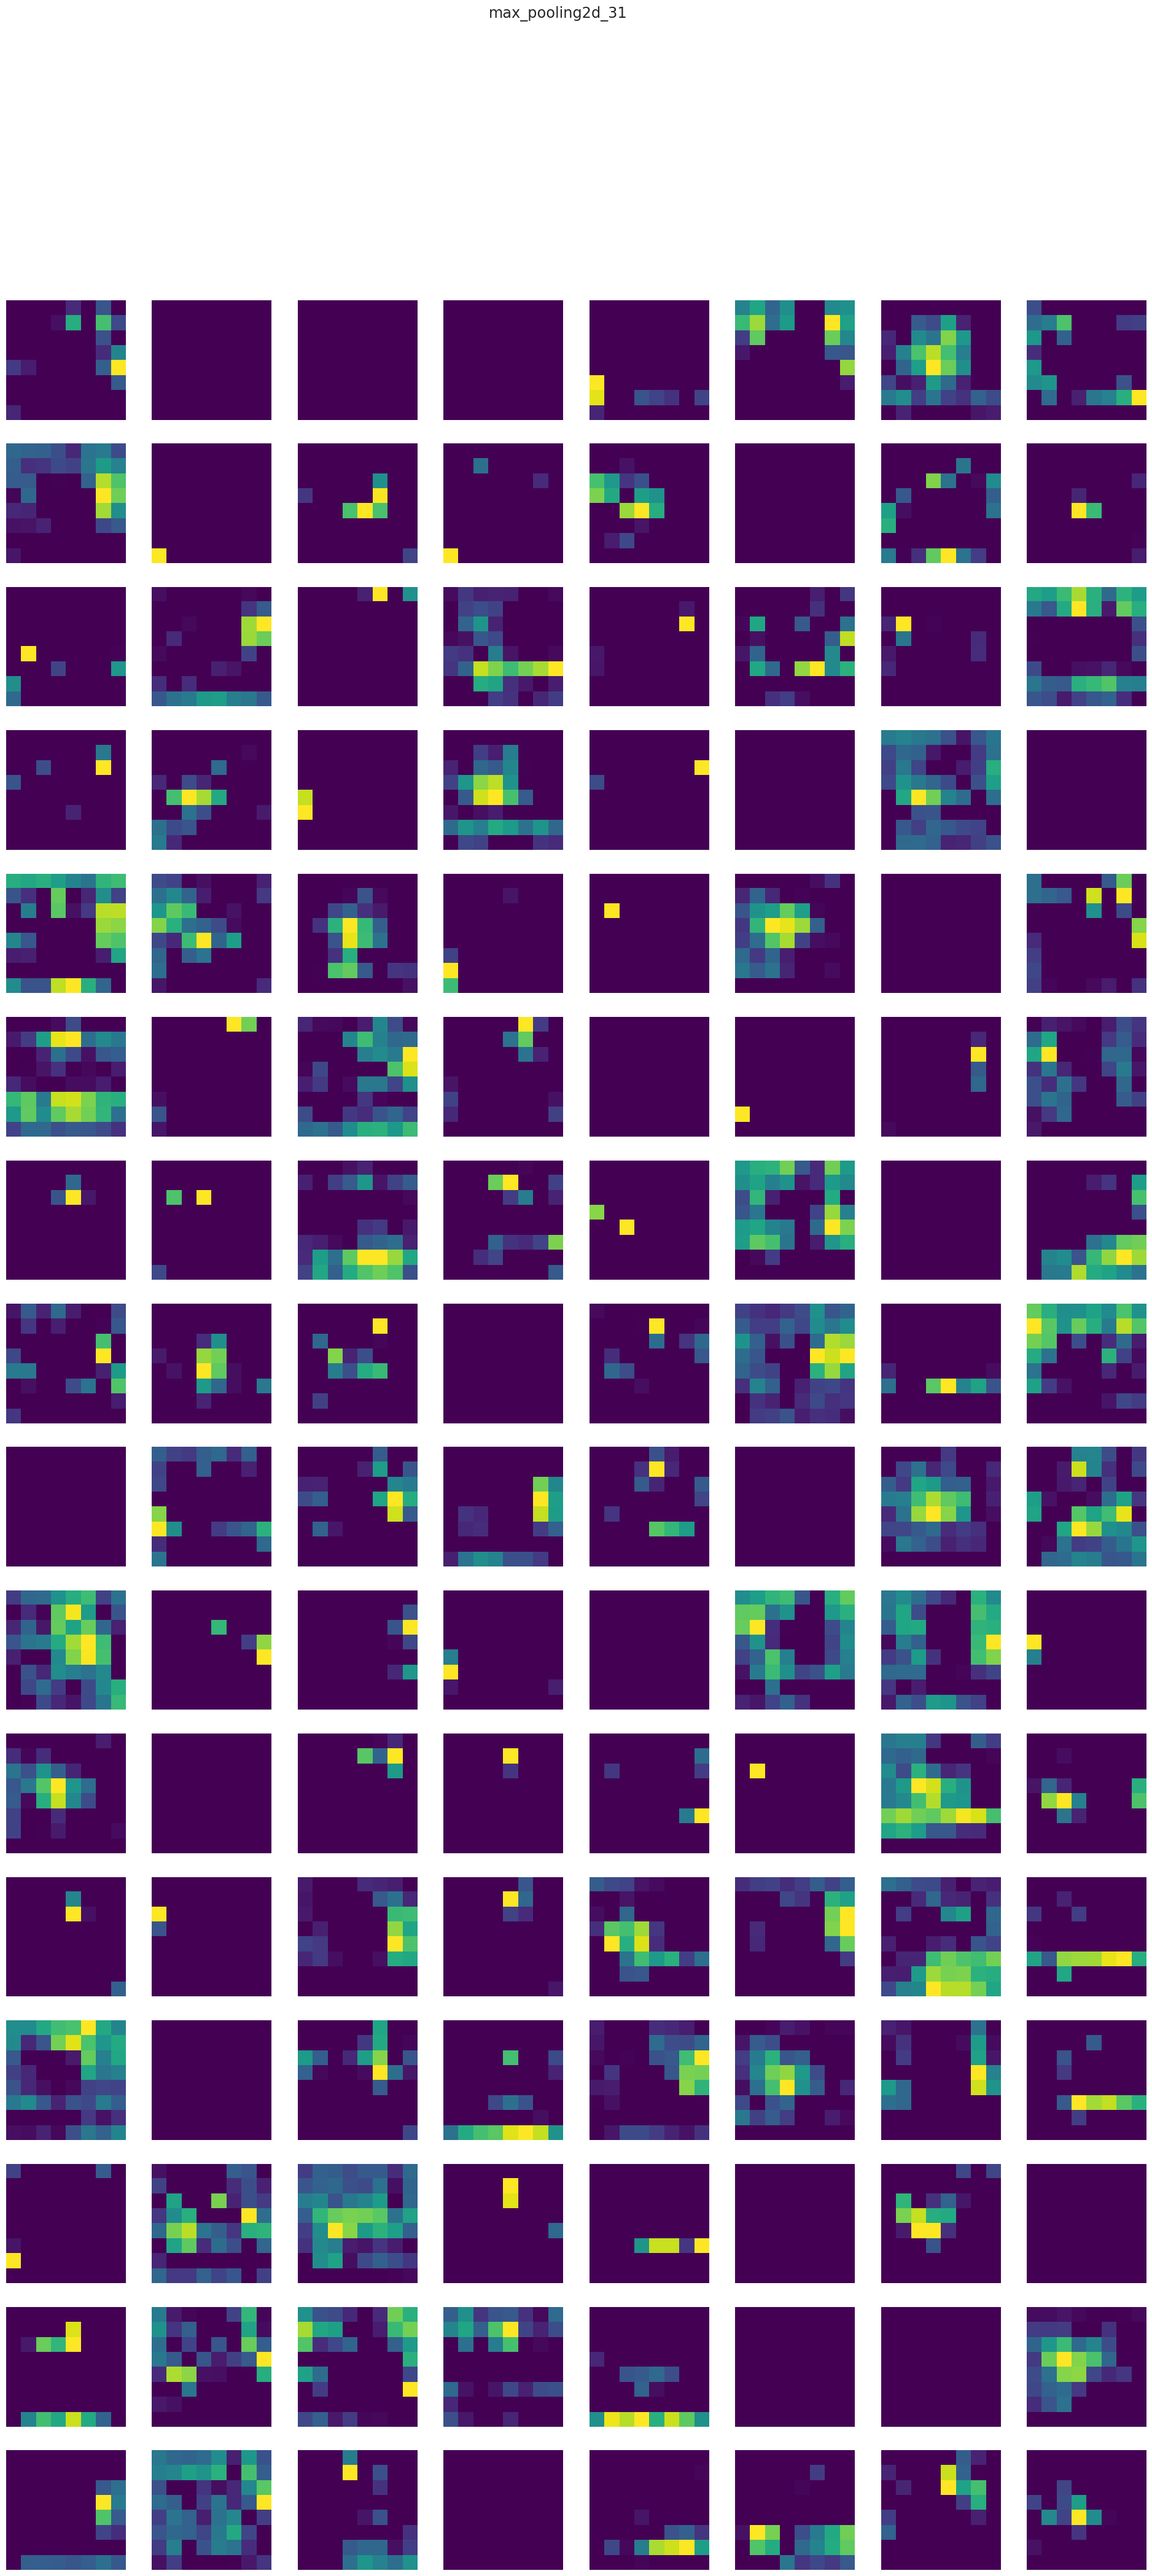

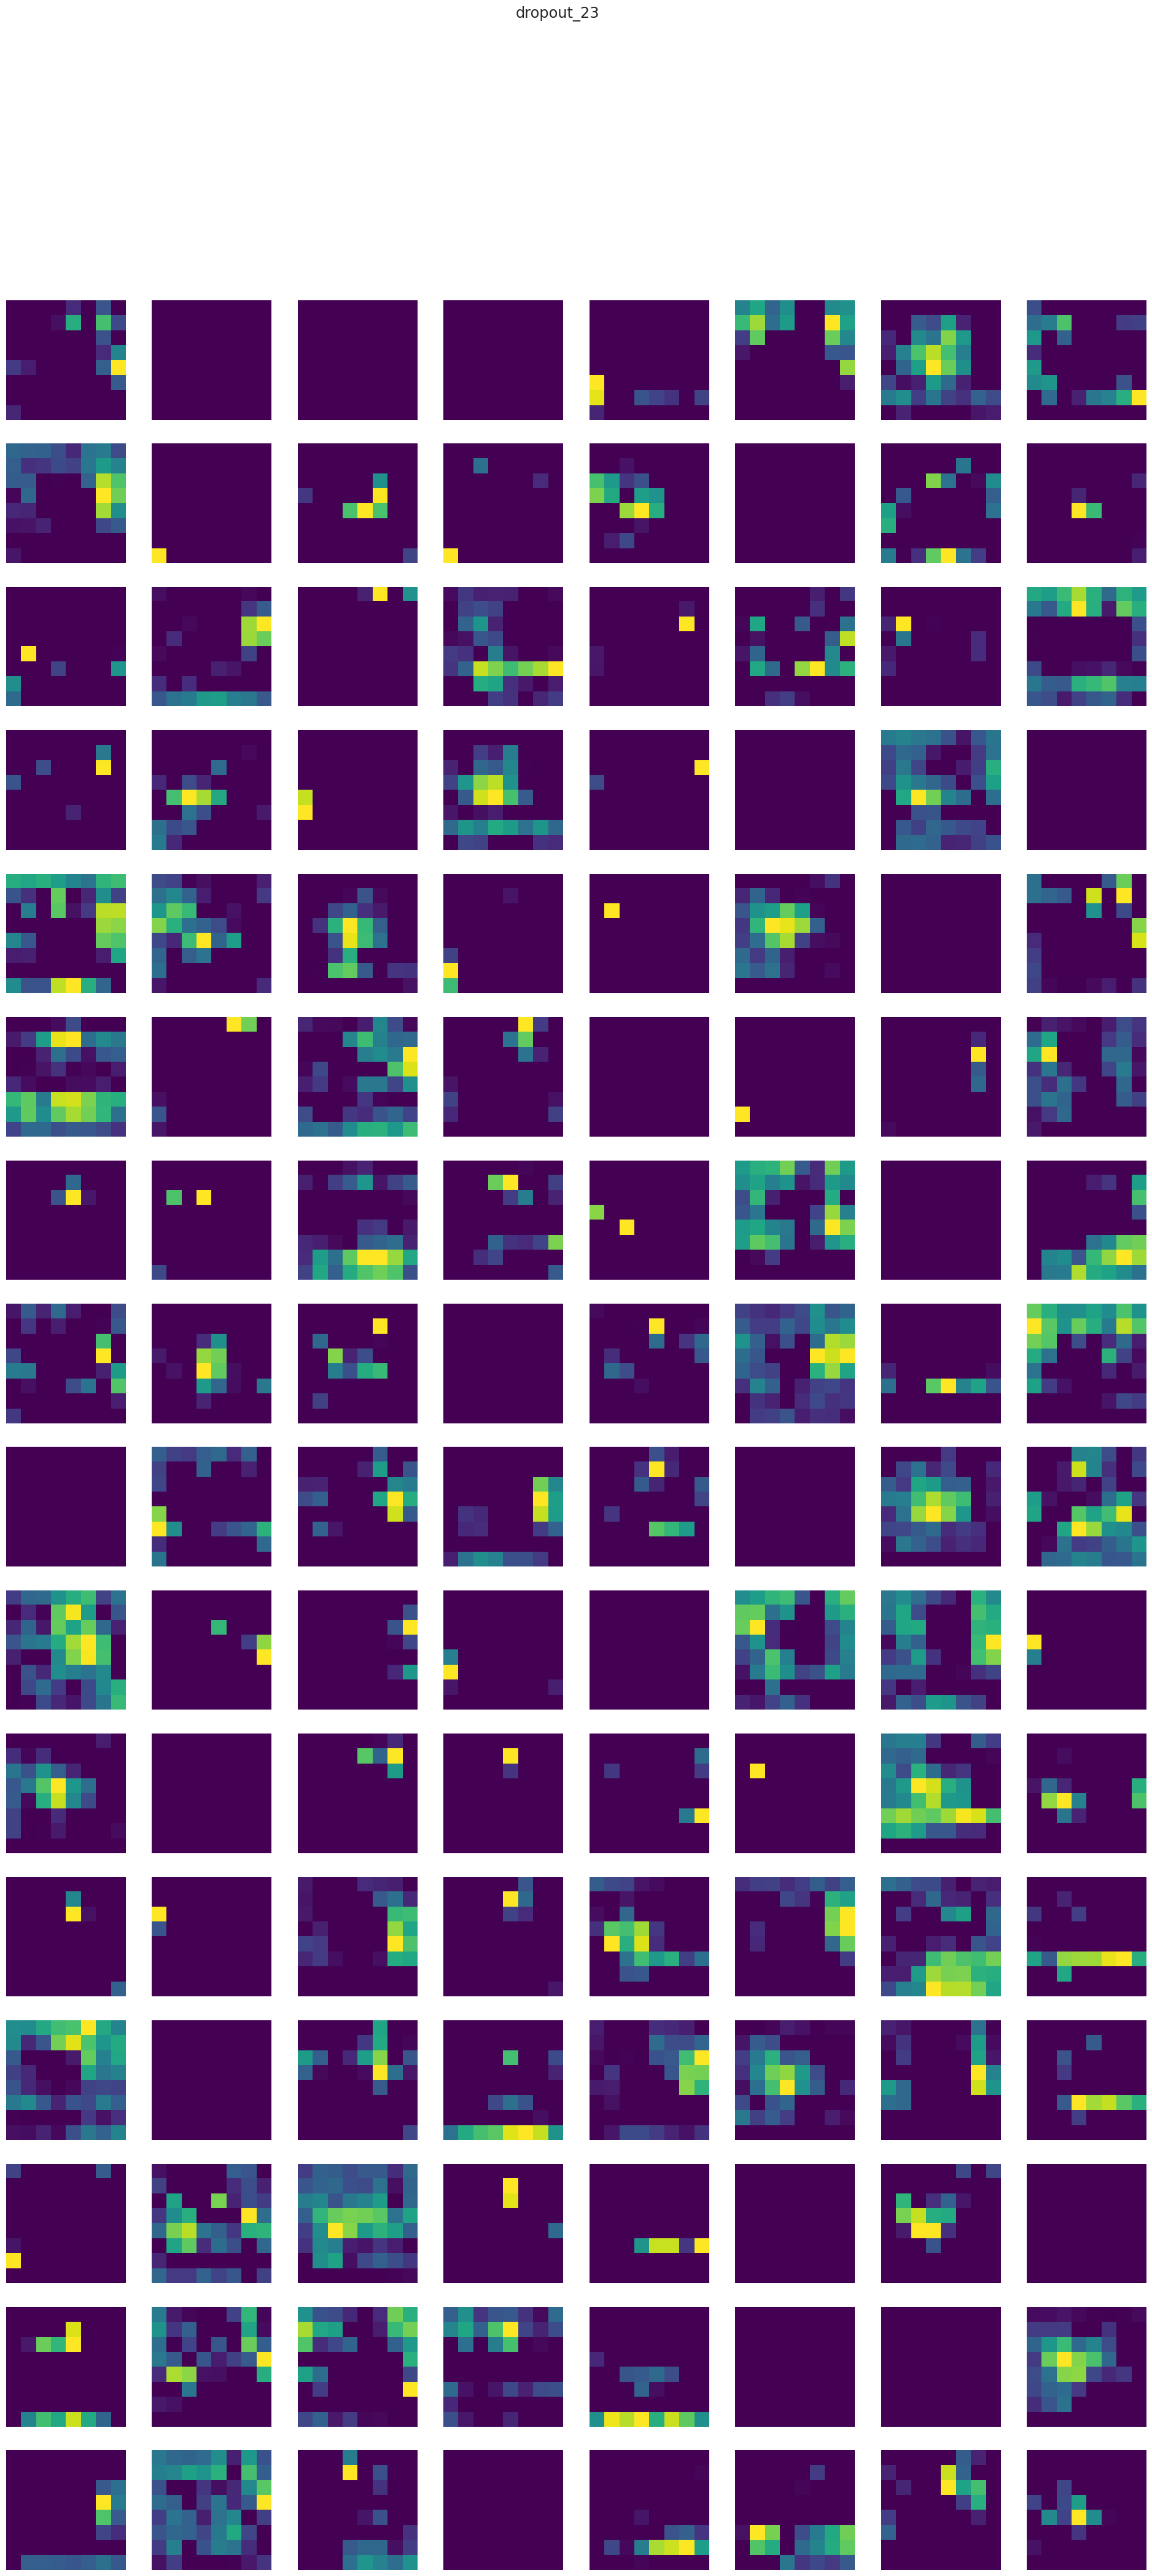

In [127]:

# Create a function to visualize feature maps for all layers
def visualize_feature_maps(model, image):
    # Create a list to store activations for each layer
    layer_outputs = [layer.output for layer in model.layers]

    # Create a new model that will output activations
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Get activations for the input image
    activations = activation_model.predict(image.reshape(1, 64, 64, 3))

    # Loop through the layers and plot the activations
    for layer_name, activation in zip(layer_names, activations):
        if len(activation.shape) == 4:  # Check if the layer produces feature maps
            num_features = activation.shape[-1]
            size = activation.shape[1]

            # Handle the case where there are no features (num_features is zero)
            if num_features == 0:
                continue

            # Calculate the number of columns and rows for the grid
            n_cols = min(num_features, 8)  # Adjust the number of columns as needed (e.g., 8)
            n_rows = (num_features + n_cols - 1) // n_cols

            plt.figure(figsize=(n_cols * 3, n_rows * 3))
            for i in range(num_features):
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(activation[0, :, :, i], cmap='viridis')
                plt.axis('off')

            plt.suptitle(layer_name)  # Set the layer name as the title
            plt.show()

# Get the names of all layers in the model
layer_names = [layer.name for layer in model.layers]

# Get an example image from the test set (we can modify this to get different images)
sample_image, _ = test_generator[0]  # Get the first image from the test set
sample_image = sample_image[0]  # Take the first image from the batch

# Visualize feature maps for all layers
visualize_feature_maps(model, sample_image)


### Basic CNN Model

In [110]:
from tensorflow import keras
from tensorflow.keras import layers
    # Define the CNN model
model2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    validation_steps=validation_generator.samples // BATCH_SIZE)


Epoch 1/5
622/622 [==============================] - 449s 722ms/step - loss: 0.2349 - accuracy: 0.9003 - val_loss: 0.2339 - val_accuracy: 0.9053
Epoch 2/5
622/622 [==============================] - 435s 700ms/step - loss: 0.2550 - accuracy: 0.8905 - val_loss: 0.2590 - val_accuracy: 0.8954
Epoch 3/5
622/622 [==============================] - 445s 716ms/step - loss: 0.2177 - accuracy: 0.9095 - val_loss: 0.1922 - val_accuracy: 0.9214
Epoch 4/5
622/622 [==============================] - 433s 696ms/step - loss: 0.2128 - accuracy: 0.9111 - val_loss: 0.2627 - val_accuracy: 0.8970
Epoch 5/5
622/622 [==============================] - 448s 720ms/step - loss: 0.1955 - accuracy: 0.9193 - val_loss: 0.2585 - val_accuracy: 0.8939


### Basic Model Evaluation

In [111]:
# Evaluvate for train generator
loss2,acc2 = model2.evaluate(train_generator,batch_size = BATCH_SIZE, verbose = 0)

print('The accuracy of the model2 for training data is:',acc2*100)
print('The Loss of the model2 for training data is:',loss2)

# Evaluvate for validation generator
loss2,acc2 = model2.evaluate(validation_generator,batch_size = BATCH_SIZE, verbose = 0)

print('The accuracy of the model2 for validation data is:',acc2*100)
print('The Loss of the model2 for validation data is:',loss2)

The accuracy of the model2 for training data is: 49.806639552116394
The Loss of the model2 for training data is: 0.7056264877319336
The accuracy of the model2 for validation data is: 50.756531953811646
The Loss of the model2 for validation data is: 0.7055335640907288
